In [1]:
%matplotlib inline
import os
import glob
import copy
import h5py
import numpy as np
from pathlib import Path
from itertools import cycle
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.colors import LogNorm, SymLogNorm, Normalize, ListedColormap

from scipy import integrate
from scipy.signal import windows
from scipy.interpolate import interp1d, UnivariateSpline as USpline

from pyuvdata import UVData, UVBeam, utils as uvutils
import pyuvdata

import simpleDS as sds
from simpleDS import  DelaySpectrum, utils, cosmo

from astropy import units, constants as const
from astropy.coordinates import Angle
from astropy.visualization import quantity_support
from astropy.cosmology import LambdaCDM, WMAP9, Planck15

In [2]:
quantity_support();

In [3]:
def estimate_noise(uv_in, return_data=False):
    """
    Estimates the noise by differencing in time.
    
    Assumes a single baseline type exists on input UVData object.
    """
    times = np.unique(uv.time_array)
    if len(times) % 2 ==1:
        times = times[:-1]
    _uv1 = uv.select(times=times[0::2], inplace=False)
    _uv2 = uv.select(times=times[1::2], inplace=False)
    data_diff = (_uv1.data_array.imag - _uv2.data_array.imag) / np.sqrt(2.)
    flags = np.logical_or(_uv1.flag_array, _uv2.flag_array)
    data_diff = np.ma.masked_array(data_diff, mask=flags)
    # take std of the mean as the nosie estimate
    # noise_est = np.std(data_diff[0, 0, 0, 0].reshape(1* (ds.Ntimes -1), ds.Nfreqs), axis=0)/np.sqrt(1 * (ds.Ntimes-1) * 1 - 1)
    noise_est = np.ma.sum(np.real(data_diff)**2, axis=(0,1))/(np.ma.sum(~data_diff.mask, axis=(0,1)) -1) #/np.sqrt(ds.Nbls * (ds.Ntimes-1) - 1)
    noise_est = np.sqrt(noise_est)
    noise_spline = np.zeros_like(noise_est)
    # a test where we interpolate through the flags
    for pol_cnt in range(uv.Npols):
        spline = USpline(uv.freq_array[0][~noise_est[:, pol_cnt].mask], noise_est[:, pol_cnt].compressed(), s=7)
        noise_spline[:, pol_cnt] = spline(uv.freq_array[0])
    if not return_data:
        return noise_spline
    else:
        return noise_spline, noise_est

In [4]:
def sci_notation(num, err=None, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if isinstance(num, units.Quantity):
        unit = num.unit
        num = num.value
       
    else:
        unit = units.dimensionless_unscaled
    if exponent is None:
        exponent = np.int(np.floor(np.log10(np.abs(num))))
    coeff = np.round(num / np.float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits
    if err is not None:
        err = err.to_value(unit)
        uncert = np.round(err / np.float(10**exponent), decimal_digits)
            
        return r"(${0:.{3}f} \pm {1:.{3}f}) \cdot10^{{{2:d}}}$ {4}".format(coeff, uncert, exponent, precision, unit.to_string("latex"))
    else:
        return r"${0:.{2}f}\cdot10^{{{1:d}}}$ {3}".format(coeff, exponent, precision, unit.to_string("latex"))
        

In [5]:
def get_zscores(ds_in, phase=False, noise=False):
    _data = ds_in.data_array.value
    _flag =  np.broadcast_to(ds_in.flag_array, _data.shape)
    if not phase and not noise:
        _data = np.ma.masked_array(np.abs(_data), mask=_flag)
    elif phase and not noise:
        _data = np.ma.masked_array(np.angle(_data), mask=_flag)
    elif noise and phase:
        _data = ds_in.noise_array.value
        _data = np.ma.masked_array(np.angle(_data), mask=_flag)
    else:
        _data = ds_in.noise_array.value
        _data = np.ma.masked_array(np.abs(_data), mask=_flag)
    _med = np.ma.median(_data, axis=3,  keepdims=True)
    _mad = np.ma.median(np.abs(_data - _med), axis=3, keepdims=True)
    z_score = 0.6745 * (_data - _med) / _mad
    return z_score, _mad

In [6]:
def est_ssins(ds):
    _data = ds.data_array.value
    _flag = ds.flag_array
    _data = np.ma.masked_array(_data, mask=_flag)
    #  squeeze out that axis
    _data = np.ma.diff(_data, axis=1)[:, 0]
    _data = np.ma.abs(_data)
    _data = np.ma.mean(_data, axis=2)
#     _mean = np.ma.mean(_data, axis=2, keepdims=True)
#     _data -= _mean
#     std = np.ma.std(_data, axis=2, keepdims=True)
#     ssins = _data/std
    _med = np.ma.median(_data, axis=2,  keepdims=True)
    _mad = np.ma.median(np.ma.abs(_data - _med), axis=2, keepdims=True)
    ssins = 0.6745 * (_data - _med) / _mad
    return ssins, _mad

In [7]:
# print version info
for m in [np, sds, pyuvdata]:
    print("{} verison {}".format(m.__name__, m.__version__))

numpy verison 1.18.1
simpleDS verison 2.0.1.dev13+g9c5b33f.update.thermal.calc.dirty
pyuvdata verison 2.1.3.dev12+gcb876788


In [8]:
BASE_DIR = Path("/data7/HERA_shadow_pipeline/")
DATA_PATH =  BASE_DIR / "simpleDS/"
BEAM_PATH = BASE_DIR / "HERA_beams"
data_files = sorted(DATA_PATH.glob("set1/*"))
beam_file = BEAM_PATH / "NF_HERA_dipole_linpol_power_healpix128.fits"
outfile = DATA_PATH / "set1_integrated_power_spectra_short_good_flags.hdf5"
# outfile = DATA_PATH / "set1_integrated_power_spectra.hdf5"
# outfile = DATA_PATH / "set1_fringe_subtracted_integrated_power_spectra.hdf5"
spws = [[175, 335], [520, 680]]
# spws = [[165, 345], [515, 695]]
# lst_chunks = []
# lst_chunks = [(4.5, 6.5)]
# lst_chunks = [(1.5, 2.7), (4.5, 6.5)]
lst_chunks = [(1.5, 2.5), (5.65, 6.5)]
#[[0, 383]]
trcvr = 50 * units.K
taper = windows.blackmanharris

In [9]:
cmap = copy.copy(plt.cm.viridis)
cmap.set_bad('black')

In [10]:
uvb = UVBeam()
uvb.read_beamfits(beam_file)

In [11]:
uv = UVData()
uv.read(data_files, read_data=False, file_type='uvh5')
uv.read(
    data_files,
    file_type='uvh5',
    polarizations=np.intersect1d(
        uvb.polarization_array, uv.polarization_array
    ),
    axis="blt",
    read_data=False
)

LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.28190.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.37586.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.46983.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.56380.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.65776.HH.uvh5 are not self-consistent with time_array and telescope location. 

In [12]:
uv.conjugate_bls("u>0")

In [13]:
bl_gps, vecs, gp_lens = uv.get_redundancies(tol=.5, use_antpos=False, conjugate_bls=True)

In [14]:
print(f"{'ind':<5} {'Nbls':<5} {'|uvw|':<10} UVW")
for ind, bl_gp in enumerate(bl_gps):
    if gp_lens[ind] > 13 and gp_lens[ind] < 100:
        if vecs[ind][0] > 1 and np.abs(vecs[ind][1]) < 50:
                print(f"{ind:<5} {len(bl_gp):<5} {gp_lens[ind]:<10.2e} {vecs[ind]}")

ind   Nbls  |uvw|      UVW
1     14    1.47e+01   [7.35000020e+00 1.27305733e+01 1.77651425e-07]
2     11    2.55e+01   [ 2.20500002e+01  1.27305731e+01 -2.03684283e-07]
4     10    2.94e+01   [1.47000004e+01 2.54611467e+01 3.55302556e-07]
5     8     3.89e+01   [ 2.94000004e+01  2.54611464e+01 -2.59898496e-08]
6     7     3.89e+01   [7.35000059e+00 3.81917202e+01 9.13971132e-07]
7     7     4.41e+01   [2.20500006e+01 3.81917199e+01 5.32844069e-07]
8     4     5.30e+01   [3.67500006e+01 3.81917197e+01 1.51648373e-07]
13    14    1.47e+01   [ 7.34999980e+00 -1.27305735e+01 -5.58764463e-07]
14    13    1.47e+01   [ 1.47000000e+01 -2.26552492e-07 -3.81231543e-07]
15    11    2.94e+01   [ 2.94000000e+01 -4.53004053e-07 -7.62293242e-07]
16    6     3.89e+01   [ 3.67500002e+01  1.27305729e+01 -5.84583087e-07]
17    3     5.09e+01   [ 4.41000004e+01  2.54611462e+01 -4.07071639e-07]
21    9     3.89e+01   [ 2.93999996e+01 -2.54611473e+01 -1.49891866e-06]
22    10    2.55e+01   [ 2.20499998e+01

In [15]:
# bl_cross = [bl_gps[1], bl_gps[13], bl_gps[14]] # one spacing
bl_cross = [bl_gps[4], bl_gps[15], bl_gps[38]] # two spacing
# bl_cross = [bl_gps[7], bl_gps[25], bl_gps[37]] # three spacing

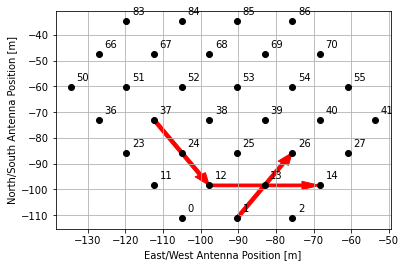

In [16]:
antpos, ants = uv.get_ENU_antpos(pick_data_ants=False)
x, y, z = antpos.T
fig, ax = plt.subplots(1, facecolor='white')
plt.plot(x,y, 'ko');

# ax1.set_xlim([50, 175])
# ax1.set_ylim([200,300])
for _ant, (_x,_y) in zip(ants, zip(x,y)):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    if np.logical_and(
        _x >= np.min(xlims), _x < np.max(xlims)
    ) and  np.logical_and(
        _y >= np.min(ylims), _y < np.max(ylims)
    ):
        ax.text(_x +1.5, _y + 2.5, _ant)

for gp in bl_cross:
    bl = gp[0]
    bl_ind = np.nonzero(uv.baseline_array == bl)[0][0]
    a1, a2 = uv.baseline_to_antnums(bl)
    ind1 = np.argwhere(ants == a1)
    ax.arrow(
        x[ind1].squeeze(),
        y[ind1].squeeze(),
        uv.uvw_array[bl_ind, 0],
        uv.uvw_array[bl_ind, 1],
        length_includes_head=True, 
        color='red',
        width=1.0625,
    )

ax.grid()
ax.set_xlabel("East/West Antenna Position [m]");
ax.set_ylabel("North/South Antenna Position [m]");

In [17]:
all_bls = [tuple(m) for m in np.transpose(uv.baseline_to_antnums(np.concatenate(bl_cross)))]
bl_cross = [[tuple(m) for m in np.transpose(uv.baseline_to_antnums((gp)))] for gp in bl_cross]

In [18]:
uv.read(
    data_files[:],
    file_type='uvh5',
    polarizations=np.intersect1d(
        uvb.polarization_array, uv.polarization_array
    ),
    read_data=True,
    bls=all_bls,
    axis="blt",
)

LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.28190.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.37586.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.46983.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.56380.HH.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /data7/HERA_shadow_pipeline/simpleDS/set1/zen.grp1.of1.LST.0.65776.HH.uvh5 are not self-consistent with time_array and telescope location. 

In [19]:
uv.conjugate_bls("u>0")
uv.set_uvws_from_antenna_positions()
uv.set_lsts_from_time_array()

In [20]:
# flag everything between 3 and 4 hours. Fornax is terrible.
good_lsts = np.zeros_like(uv.flag_array, dtype=np.bool)
for lst in lst_chunks:
    inds = np.logical_and(lst[0] <= uv.lst_array * 12. / np.pi, uv.lst_array * 12/np.pi <= lst[1]).reshape(-1, 1, 1, 1)
    good_lsts |= inds
# uv.flag_array = np.logical_or(np.logical_and( 3<= uv.lst_array * 12./np.pi, uv.lst_array * 12./np.pi <= 4.).reshape(-1, 1, 1, 1), uv.flag_array)
uv.flag_array |= np.logical_not(good_lsts)
# uv.flag_array |= uv.nsample_array == 0

In [21]:
d_nu = (uv.freq_array[0, 680] - uv.freq_array[0, 520]) * units.Hz
nu = uv.freq_array[0, 520:680].mean() * units.Hz
beam_crossing = (1.22 * ((const.c/nu).to("m"))/(gp_lens[4] * units.m) * 12 * units.h / (np.pi * np.cos(uv.telescope_location_lat_lon_alt[1]))).to("min")

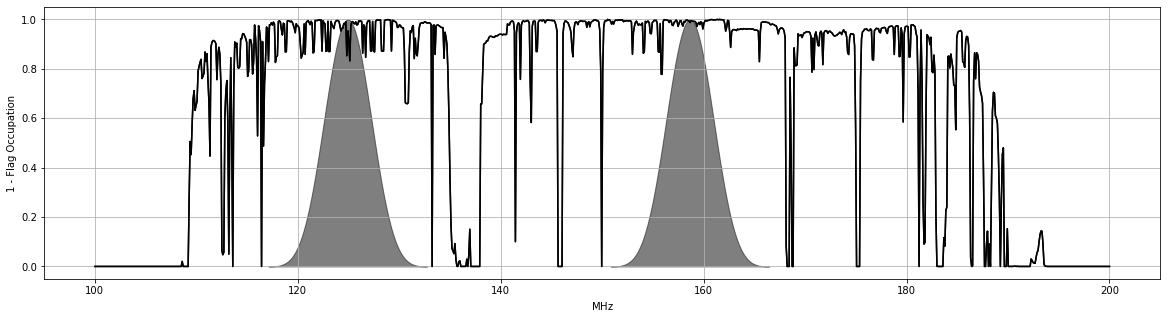

In [22]:
fig, ax = plt.subplots(1, figsize=(20,5))
freqs = uv.freq_array[0] * units.Hz
flags = uv.nsample_array.astype(float).squeeze()
ax.plot(
    freqs.to("MHz"),
    flags.sum(0)/flags.sum(0).max(),
    'k-'
);

for chan in spws:
    mid = np.mean(chan)
    _w = windows.blackmanharris(chan[1] - chan[0] + 1)
    ax.fill_between(freqs[chan[0] : chan[1] + 1].to('MHz'), 0, _w, color='black',alpha=.5 )
ax.set_ylabel("1 - Flag Occupation")
ax.grid()

A simulation of noise is constructed by differencing the data between adjacent time steps.

This simulation will be analyzed alongside the data to provide a check that the data has not been inegrated below the noise floor.
A second estimate of the noise uncertainty uses a 50K receiver temperature to estimate the expected power spectrum of noise.

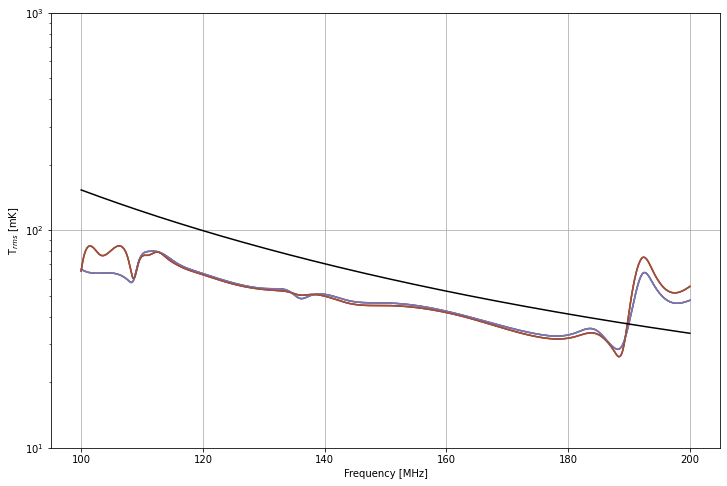

In [23]:
fig,ax = plt.subplots(1, figsize=(12,8))

uv_noise = None
cnt=0
for gp in bl_cross:
    uv_tmp = uv.select(bls=gp, inplace=False)
    est, dat = estimate_noise(uv_tmp, return_data=True)
    _uv_noise_tmp = uv_tmp.copy()
    _uv_noise_tmp.data_array = np.copy(
        est.reshape(1, 1, *est.shape) 
        * (
            1. * np.random.normal(size=_uv_noise_tmp.data_array.shape) 
            + 1j * np.random.normal(size=_uv_noise_tmp.data_array.shape)
        ) / np.sqrt(2)
    )
    
    if uv_noise is not None:
        uv_noise += _uv_noise_tmp
    else:
        uv_noise = _uv_noise_tmp.copy()

    for pol_cnt, pol in enumerate(uvutils.polnum2str(uv_tmp.polarization_array)):
        beam = USpline(uvb.freq_array[0], uvb.get_beam_area(pol),)
        ax.plot((uv_tmp.freq_array[0] * units.Hz).to("MHz"), est[:, pol_cnt] * units.Jy * utils.jy_to_mk(uv_tmp.freq_array[0] * units.Hz) / (beam(uv_tmp.freq_array[0]) * units.sr), f"C{cnt}-");
#         ax.plot((uv_tmp.freq_array[0] * units.Hz).to("MHz"), dat[:, pol_cnt] * units.Jy * utils.jy_to_mk(uv_tmp.freq_array[0] * units.Hz) / (beam(uv_tmp.freq_array[0]) * units.sr), f"C{cnt}o", mfc="none");
        cnt += 1
uv_noise.flag_array = uv.flag_array

tsys = 180 * np.power(
    (uv.freq_array[0] * units.Hz).to('GHz') / (.18 * units.GHz),
    -2.55,
) * units.K
tsys += trcvr
tsys <<= units.mK
# add the extra effective days term because this is lst binned data
tsys /= np.sqrt(
    2 * np.diff(uv.freq_array[0] * units.Hz)[0].to('1/s') 
    * uv.integration_time.item(0) * units.s 
    * np.sqrt(
        np.ma.mean(
            np.ma.masked_array(uv.nsample_array**2, mask=uv.flag_array)
        )
    )
)

ax.plot((uv.freq_array[0] * units.Hz).to("MHz"), tsys, 'k-')

ax.set_yscale("log");
ax.set_ylim([1e1, 1e3])
ax.set_ylabel(r"T$_{rms}$ [mK]")
ax.set_xlabel("Frequency [MHz]")
ax.grid();
plt.savefig('set1_noise_curve.pdf', bbox_inches="tight")  

In [24]:
fft_freq = lambda x: np.fft.fftshift(np.fft.fft(x * taper(x.shape[1]).reshape(1,-1), axis=1), axes=1)
fft_fringe = lambda x: np.fft.fftshift(np.fft.fft(x * taper(x.shape[0]).reshape(-1,1), axis=0), axes=0)
fringe_rates = (np.fft.fftshift(np.fft.fftfreq(uv.Ntimes, d=np.diff(np.unique(uv.lst_array * units.rad).to('hourangle'))[0].value) )/units.hour).to('mHz')

FixedFormatter should only be used together with FixedLocator


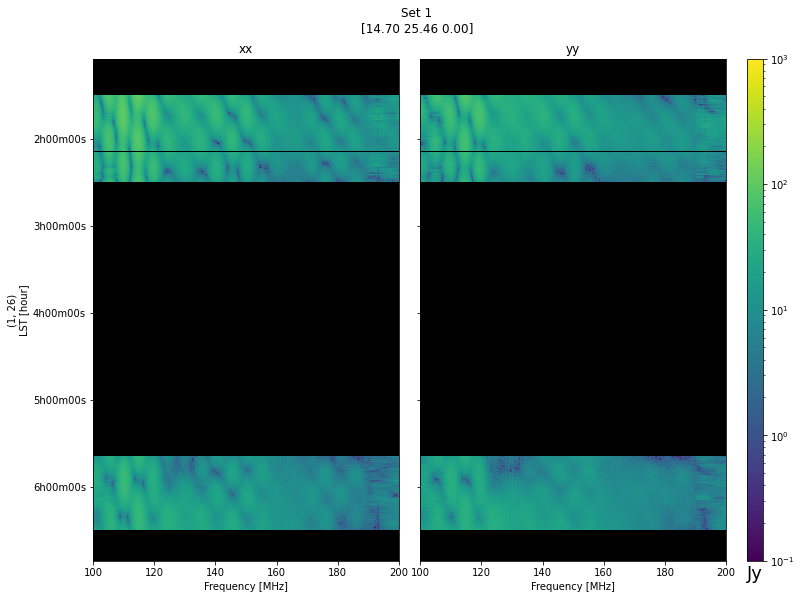

In [25]:
vmin = -5
vmax = 5
norm = LogNorm(vmin=1e-1, vmax=1e3)

fig, ax = plt.subplots(
        figsize=(12, 8 * 1 + 1),
        nrows=1,
        ncols=uv.Npols + 1, 
        sharex=False,
        sharey=False,
        facecolor='white',
        gridspec_kw={"width_ratios":[20] * uv.Npols + [1]},
        squeeze=False,
        )
fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
bl_cnt = 0
for bl_ind, bl in enumerate(np.unique(uv.baseline_array)):

    bl_inds = np.nonzero(bl == uv.baseline_array)[0]
    if np.all(uv.flag_array[bl_inds]):
        print(f"skipping {bl}")
        continue
    _uvw = r"[" + " ".join(f'{x:.2f}' for x in uv.uvw_array[bl_ind]) + "]"
    
    fig.suptitle(
        f"Set 1\n{_uvw}"
    )
    sharedy = ax[bl_cnt, 0].get_shared_y_axes()
    sharedx = ax[bl_cnt, 0].get_shared_x_axes()

    
    _lsts = uv.lst_array[bl_inds]
    
    ax[bl_cnt, 0].set_ylabel(
        f"{uvutils.baseline_to_antnums(bl, uv.Nants_telescope)}\n"
        "LST [hour]"
    )
    for pol_cnt, pol in enumerate(uvutils.polnum2str(uv.polarization_array)):

        ax[bl_cnt, pol_cnt].set_xlabel(r"Frequency [MHz]")
        sharedx.join(ax[bl_cnt, 0], ax[bl_cnt, pol_cnt])
        sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, pol_cnt])

        masked_data = np.ma.masked_array(
            uv.data_array[bl_inds, 0, :, pol_cnt],
            mask=uv.flag_array[bl_inds, 0, :, pol_cnt]
        )

        im = ax[bl_cnt, pol_cnt].pcolormesh(
            (uv.freq_array[0] * units.Hz).to('MHz'),
            (_lsts * units.rad).to("hourangle"),
            np.abs(masked_data),
            cmap=cmap,
            norm=norm,
            shading="auto",
        )
        im.set_rasterized(True)

        ax[bl_cnt, pol_cnt].set_title(f"{pol}")
        _ylim = ax[bl_cnt, pol_cnt].get_ylim()
        ax[bl_cnt, pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])


        tick_labels =  ax[bl_cnt, pol_cnt].get_yticks()
        tick_labels = [Angle(t*units.hourangle).to_string() for t in tick_labels]
        ax[bl_cnt, pol_cnt].set_yticklabels(tick_labels);

        if  0 < pol_cnt < uv.Npols:
            plt.setp(ax[bl_cnt, pol_cnt].get_yticklabels(), visible=False)
            ax[bl_cnt, pol_cnt].set_ylabel("")



    cbar = fig.colorbar(im, cax=ax[bl_cnt, -1], label="Jy")#
    cbar.ax.set_xlabel(
        cbar.ax.get_ylabel(),
        fontsize=18,
    )
    cbar.ax.set_ylabel(None)
    bl_cnt += 1
#     ax[0,0].set_xlim(130,150)
    break


plt.savefig("set1_waterfall.pdf", bbox_inches="tight")
# plt.show()


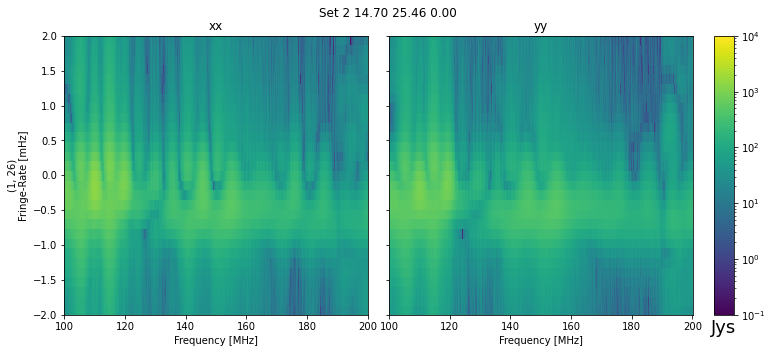

In [26]:
vmin = -5
vmax = 5
norm = LogNorm(vmin=1e-1, vmax=1e4)
_uvw = r" ".join(f'{x:.2f}' for x in uv.uvw_array[0])

lsts = np.unique(uv.lst_array)
lst_inds = np.logical_and(lsts  * 12./np.pi >= 4.5, lsts *12 /np.pi <= 6.5)
lsts = lsts[lst_inds] * units.rad
fr_rates = (np.fft.fftshift(np.fft.fftfreq(lsts.size, d=np.diff(lsts.to('hourangle'))[0].value) )/units.hour).to('mHz')

fig, ax = plt.subplots(
        figsize=(12, 4 * 1 + 1),
        nrows=1,
        ncols=uv.Npols + 1, 
        sharex=False,
        sharey=False,
        facecolor='white',
        gridspec_kw={"width_ratios":[15] * uv.Npols + [1]},
        squeeze=False,
        )
fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
fig.suptitle(
    f"Set 2 {_uvw}"
)
bl_cnt = 0
for bl_ind, bl in enumerate(np.unique(uv.baseline_array)):
    bl_inds = np.nonzero(bl == uv.baseline_array)[0]
    if np.all(uv.flag_array[bl_inds]):
        print(f"skipping {bl}")
        continue
    sharedy = ax[bl_cnt, 0].get_shared_y_axes()
    sharedx = ax[bl_cnt, 0].get_shared_x_axes()

    
    ax[bl_cnt, 0].set_ylabel(
        f"{uvutils.baseline_to_antnums(bl, uv.Nants_telescope)}\n"
        "Fringe-Rate [mHz]"
    )
    for pol_cnt, pol in enumerate(uvutils.polnum2str(uv.polarization_array)):

        ax[bl_cnt, pol_cnt].set_xlabel(r"Frequency [MHz]")
        sharedx.join(ax[bl_cnt, 0], ax[bl_cnt, pol_cnt])
        sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, pol_cnt])

        masked_data = np.ma.masked_array(
            uv.data_array[bl_inds, 0, :, pol_cnt],
            mask=uv.flag_array[bl_inds, 0, :, pol_cnt]
        )
        masked_data = masked_data[lst_inds]
#         masked_data -=masked_data.mean(0, keepdims=True)

        im = ax[bl_cnt, pol_cnt].pcolormesh(
            (uv.freq_array[0] * units.Hz).to('MHz'),
            fr_rates,
            np.abs(fft_fringe(masked_data.filled(0))),
            cmap=cmap,
            norm=norm,
            shading="auto",
        )

        ax[bl_cnt, pol_cnt].set_title(f"{pol}")
        _ylim = ax[bl_cnt, pol_cnt].get_ylim()
        ax[bl_cnt, pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

        if  0 < pol_cnt < uv.Npols:
            plt.setp(ax[bl_cnt, pol_cnt].get_yticklabels(), visible=False)
            ax[bl_cnt, pol_cnt].set_ylabel("")



    cbar = fig.colorbar(im, cax=ax[bl_cnt, -1], label="Jys")#
    cbar.ax.set_xlabel(
        cbar.ax.get_ylabel(),
        fontsize=18,
    )
    cbar.ax.set_ylabel(None)
    bl_cnt += 1
    break

ax[0,0].set_ylim(-2,2)
plt.show()

In [27]:
# target_time = np.around(beam_crossing / 4, 0)
target_time = 5 * units.min
print(target_time.to("min"))

5.0 min


The time difference between integrations is not the same as the integration time for baseline (1, 26). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 40). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 41). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 52). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (26, 55). The output may average across longer time inter

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


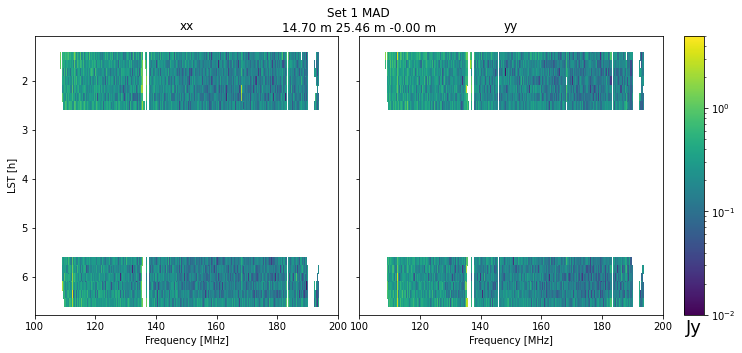

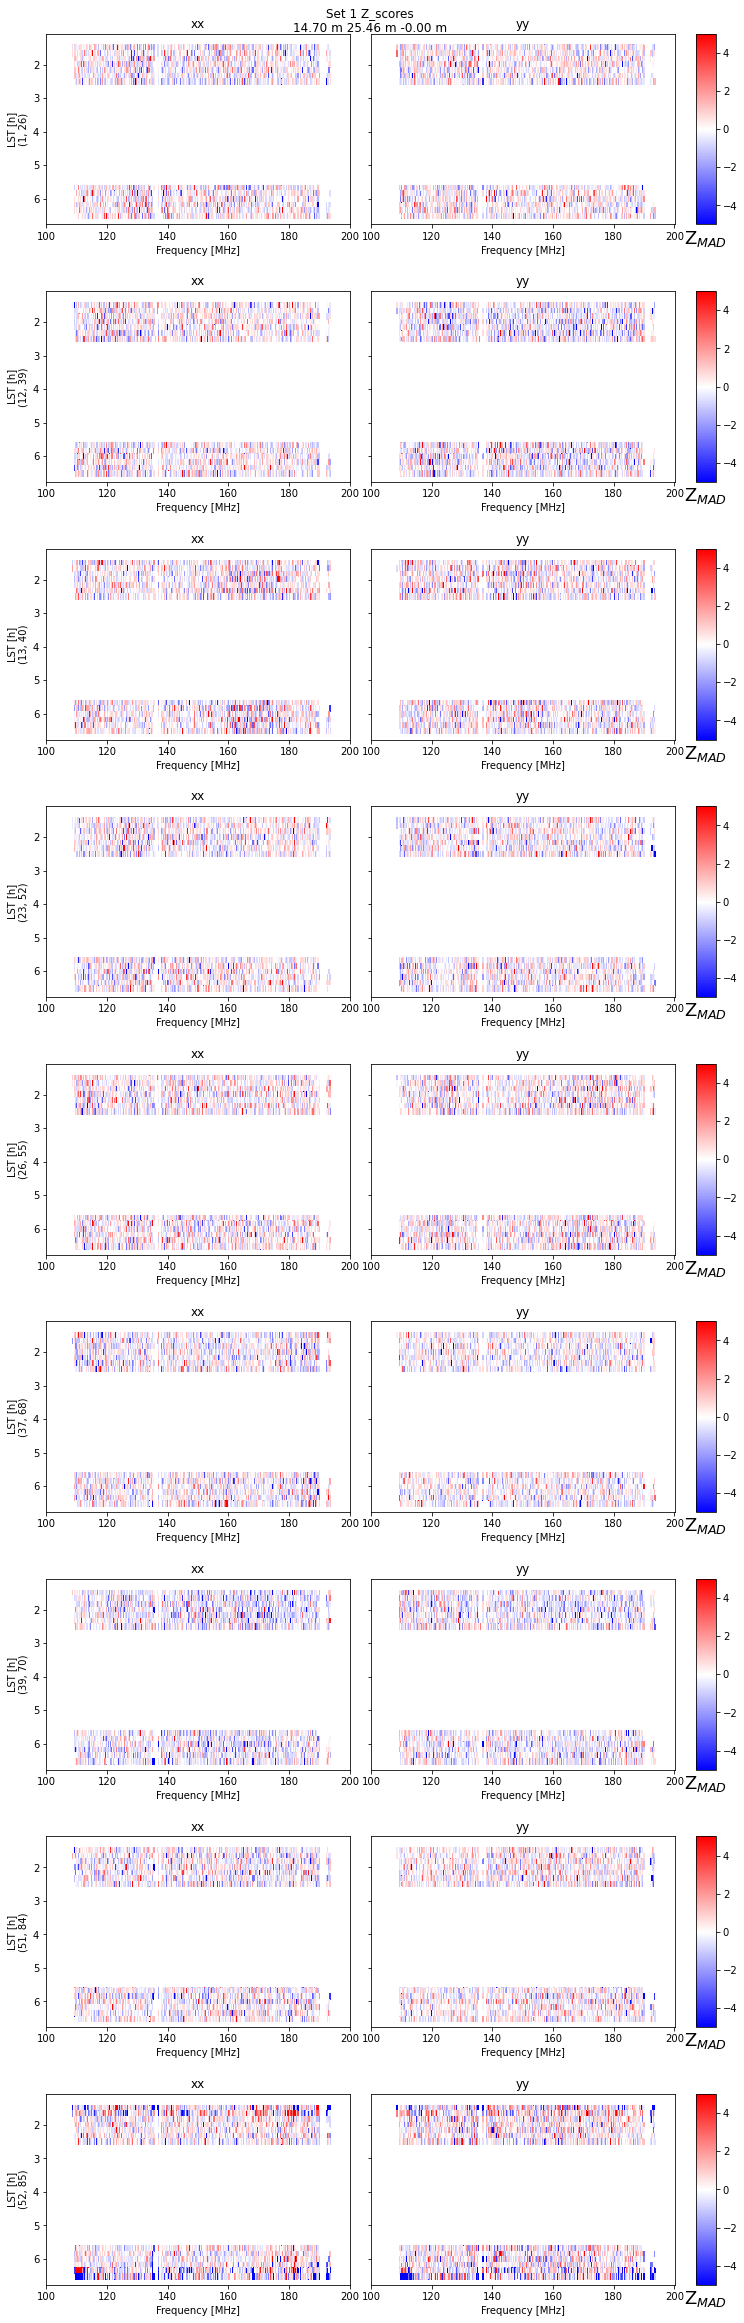

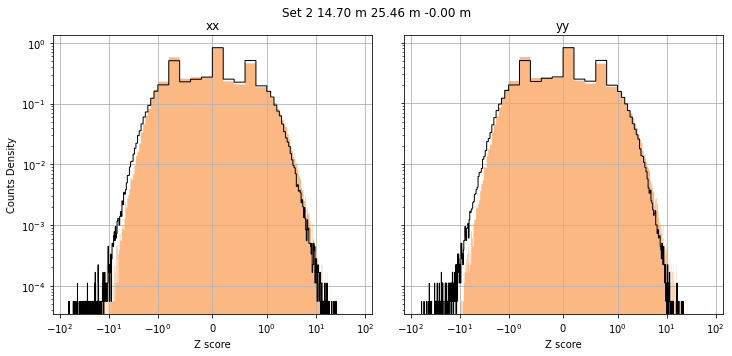

The time difference between integrations is not the same as the integration time for baseline (12, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 25). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (25, 27). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (36, 38). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (37, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (38, 40). The output may average across longer time inte

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


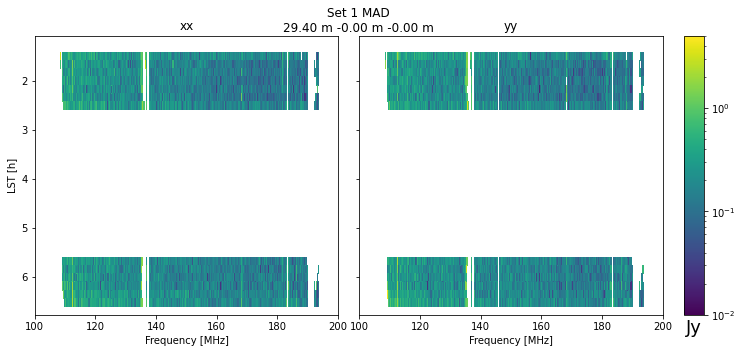

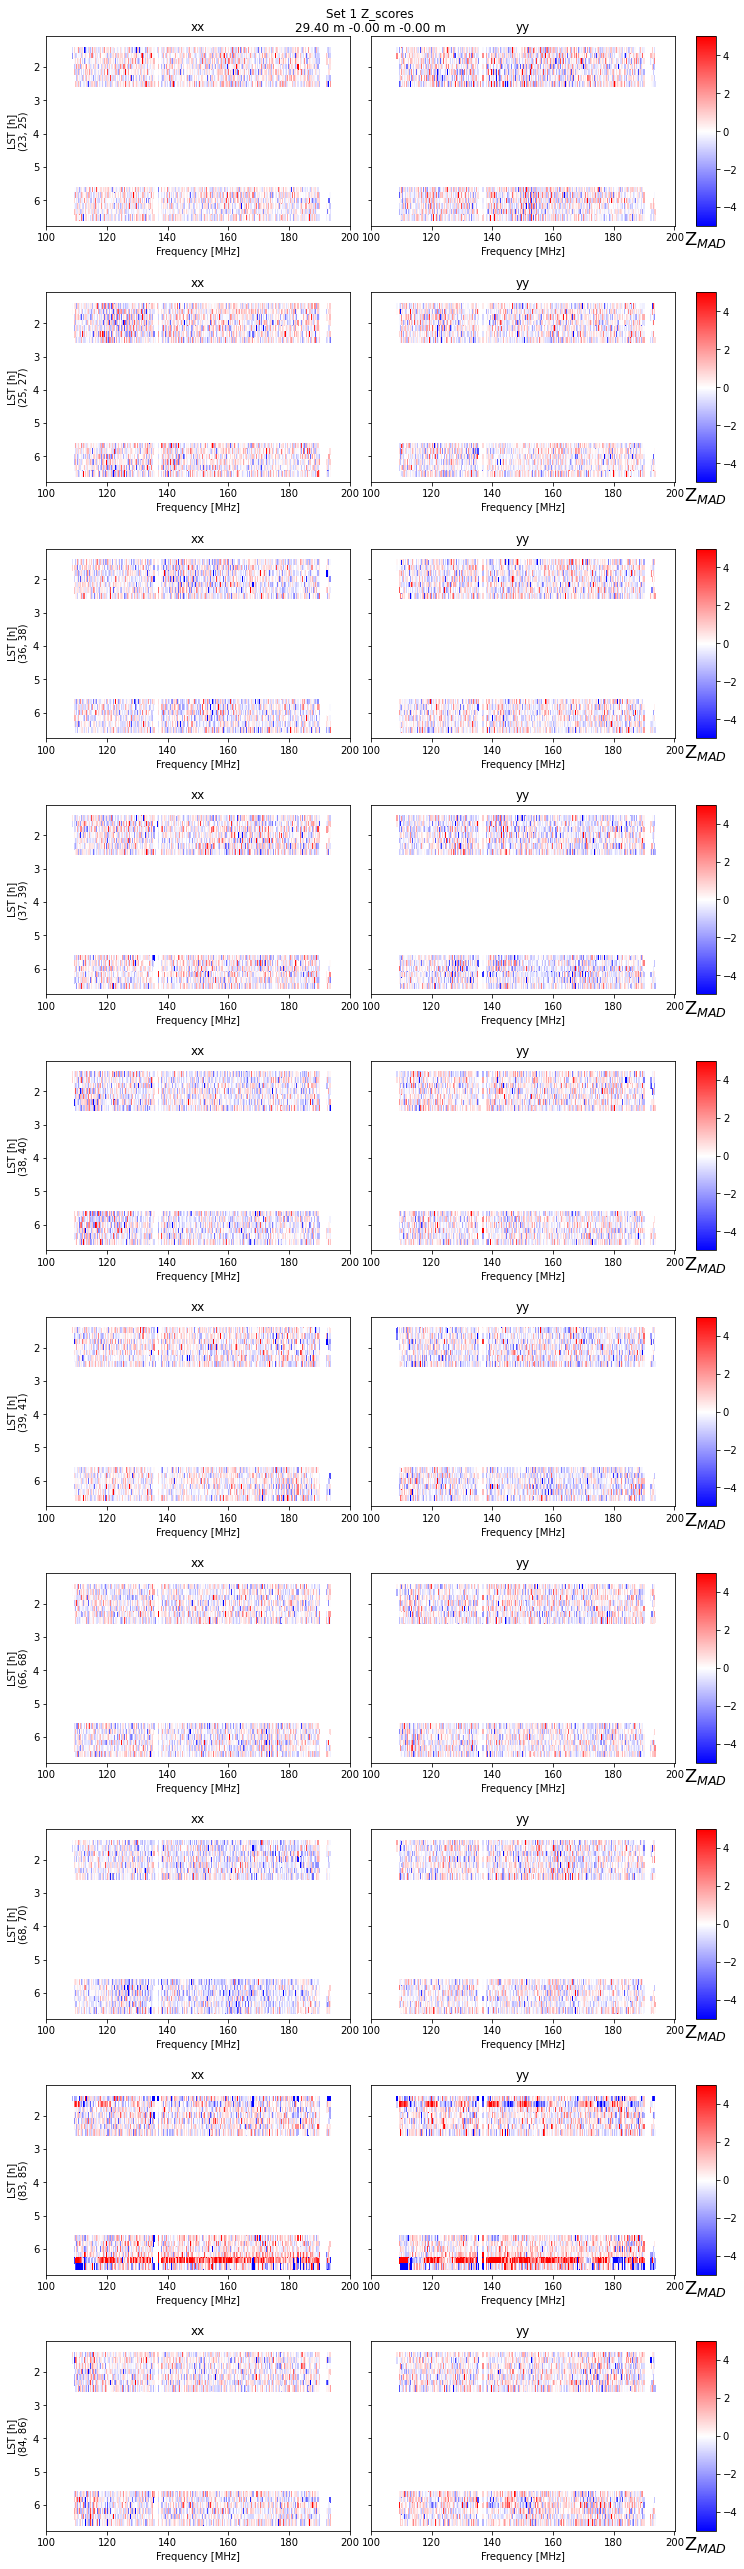

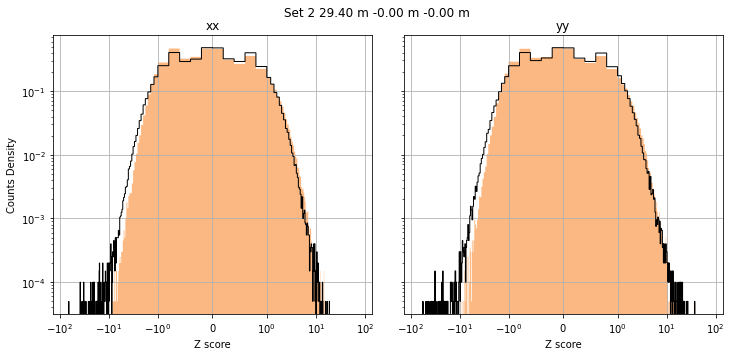

The time difference between integrations is not the same as the integration time for baseline (37, 12). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (38, 13). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (39, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (52, 25). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (66, 37). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (68, 39). The output may average across longer time inte

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


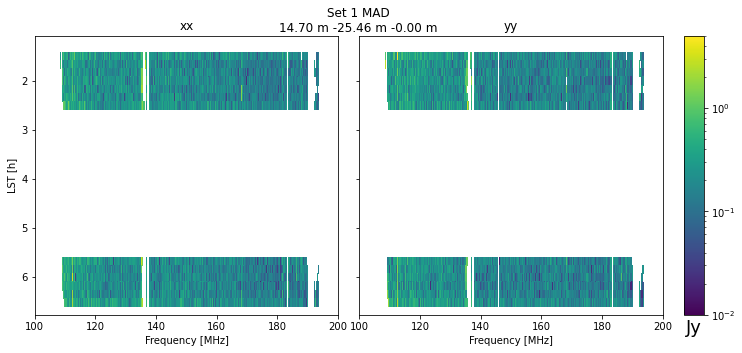

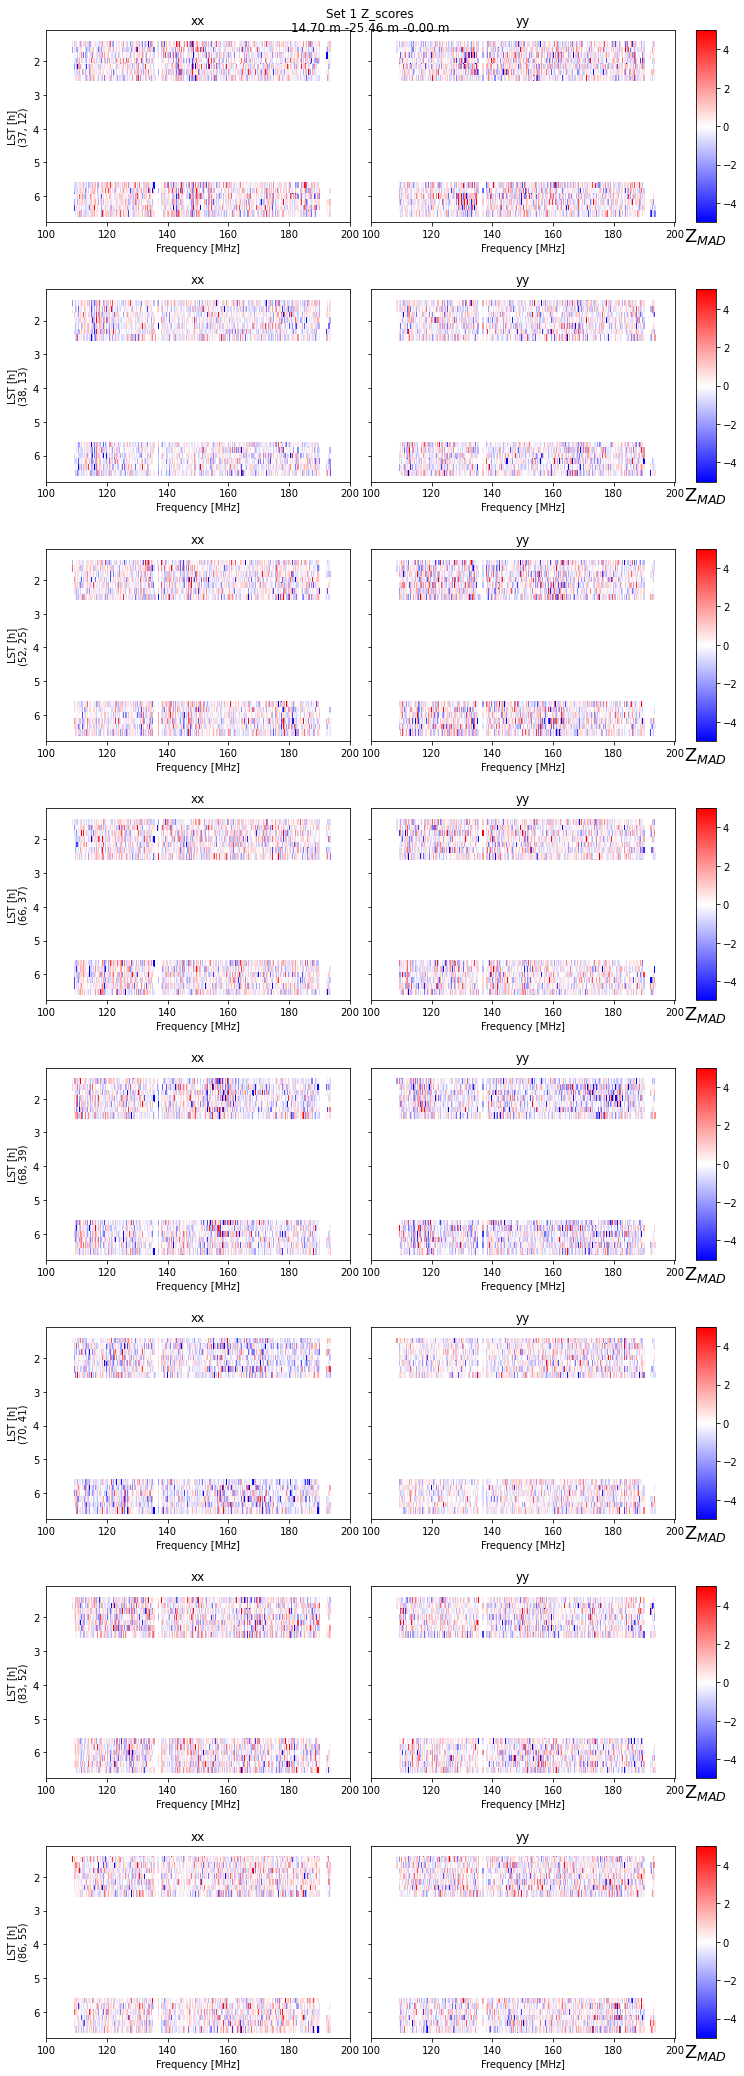

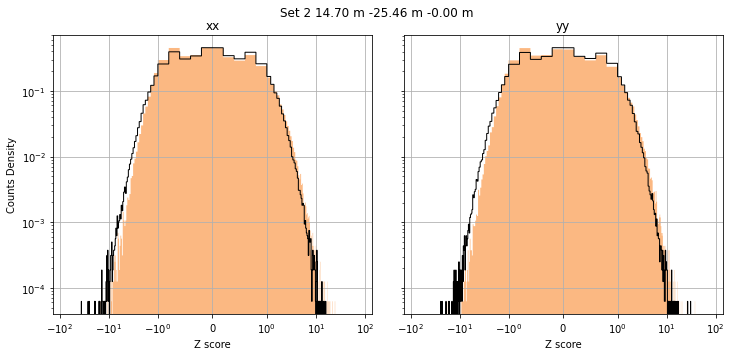

In [28]:
for gp in bl_cross:
    _uv = uv.select(bls=gp, inplace=False)
    _uv.resample_in_time(target_time.to_value("s"), keep_ragged=False)
    ds = DelaySpectrum(_uv, uvb=uvb, trcvr=50*units.K)
    
    bad_bls = [bl for bl_cnt, bl in enumerate(ds.baseline_array) if np.all(ds.flag_array[:, :, :, bl_cnt])]
    good_bls = list(set(ds.baseline_array) - set(bad_bls))

    ds.select(bls=good_bls, inplace=True)
    ds.generate_noise()
    _uvw = r" ".join(f'{x:.2f}' for x in ds.uvw)
    

    z_scores, mad = get_zscores(ds)
    z_scores_noise, mad_noies = get_zscores(ds, noise=True)
    fig, ax = plt.subplots(
        figsize=(12, 4 * 1 + 1),
        nrows=1,
        ncols=uv.Npols + 1, 
        sharex=False,
        sharey=False,
        facecolor='white',
        gridspec_kw={"width_ratios":[15] * uv.Npols + [1]},
        squeeze=True,
    )
#     norm = Normalize(vmin=0, vmax=5)
    norm = LogNorm(vmin=1e-2, vmax=5)
    fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
    fig.suptitle(
        f"Set 1 MAD\n{_uvw}"
    )
    ax[0].set_ylabel(
        "LST [h]"
    )
    for pol_cnt, pol in enumerate(uvutils.polnum2str(ds.polarization_array)):
        im = ax[pol_cnt].pcolormesh(
            ds.freq_array[0].to("MHz"),
            ds.lst_array.to("hourangle"),
            mad[0, 0, pol_cnt, 0],
            norm=norm,
            cmap=plt.cm.viridis,
            shading="auto",
        )
        ax[pol_cnt].set_xlabel(r"Frequency [MHz]")

        ax[pol_cnt].set_title(f"{pol}")
        _ylim = ax[pol_cnt].get_ylim()
        ax[pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

        if  0 < pol_cnt < uv.Npols:
            plt.setp(ax[pol_cnt].get_yticklabels(), visible=False)
            ax[pol_cnt].set_ylabel("");

    cbar = fig.colorbar(im, cax=ax[-1], label="Jy")#
    cbar.ax.set_xlabel(
        cbar.ax.get_ylabel(),
        fontsize=18,
    )
    cbar.ax.set_ylabel(None)


    fig, ax = plt.subplots(
        figsize=(12, 4 * ds.Nbls + 1),
        nrows=ds.Nbls,
        ncols=uv.Npols + 1, 
        sharex=False,
        sharey=False,
        facecolor='white',
        gridspec_kw={"width_ratios":[15] * uv.Npols + [1]},
        squeeze=True,
    )
    norm = Normalize(vmin=-5, vmax=5)
    fig.subplots_adjust(hspace=.35, wspace=0.1, top=.97)
    fig.suptitle(
        f"Set 1 Z_scores\n{_uvw}"
    )
    for bl_cnt, bl in enumerate(np.transpose(uvutils.baseline_to_antnums(ds.baseline_array, ds.Nants_telescope))):
        ax[bl_cnt, 0].set_ylabel(
            f"LST [h]\n{tuple(bl)}"
        )
        for pol_cnt, pol in enumerate(uvutils.polnum2str(ds.polarization_array)):
            im = ax[bl_cnt, pol_cnt].pcolormesh(
                ds.freq_array[0].to("MHz"),
                ds.lst_array.to("hourangle"),
                z_scores[0, 0, pol_cnt, bl_cnt],
                norm=norm,
                cmap=plt.cm.bwr,
                shading="auto",
            )
            ax[bl_cnt, pol_cnt].set_xlabel(r"Frequency [MHz]")

            ax[bl_cnt, pol_cnt].set_title(f"{pol}")
            _ylim = ax[bl_cnt, pol_cnt].get_ylim()
            ax[bl_cnt, pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

            if  0 < pol_cnt < uv.Npols:
                plt.setp(ax[bl_cnt, pol_cnt].get_yticklabels(), visible=False)
                ax[bl_cnt, pol_cnt].set_ylabel("");
            else:
                ax

        cbar = fig.colorbar(im, cax=ax[bl_cnt, -1], label=r"Z$_{MAD}$")#
        cbar.ax.set_xlabel(
            cbar.ax.get_ylabel(),
            fontsize=18,
        )
        cbar.ax.set_ylabel(None)

    fig, ax = plt.subplots(
        figsize=(12, 4 * 1 + 1),
        nrows=1,
        ncols=uv.Npols, 
        sharex=False,
        sharey=False,
        facecolor='white',
        squeeze=True,
    )
    norm = Normalize(vmin=0, vmax=5)
    fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
    fig.suptitle(
        f"Set 2 {_uvw}"
    )
    ax[0].set_ylabel(
        "Counts Density"
    )
    bins1= np.linspace(-70,70,701)

    for pol_cnt, pol in enumerate(uvutils.polnum2str(ds.polarization_array)):
        _hist,_bins, patches = ax[pol_cnt].hist(
            z_scores[0, 0, pol_cnt].compressed(),
            bins=bins1,
            density=True,
            log=True,
            histtype="step",
            color="black",
        )
        _hist,_bins, patches = ax[pol_cnt].hist(
            z_scores_noise[0, 0, pol_cnt].compressed(),
            bins=bins1,
            density=True,
            log=True,
            histtype="stepfilled",
            color="XKCD:orange",
            alpha=.5,
        )
        ax[pol_cnt].grid()
        ax[pol_cnt].set_xlabel(r"Z score")

        ax[pol_cnt].set_title(f"{pol}")
        ax[pol_cnt].set_xscale("Symlog", linthresh=1e0)

        if  0 < pol_cnt < uv.Npols:
            plt.setp(ax[pol_cnt].get_yticklabels(), visible=False)
            ax[pol_cnt].set_ylabel("");
    plt.show()

lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892324699567957 min. Keeping LST array stored from the first data set read.
Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


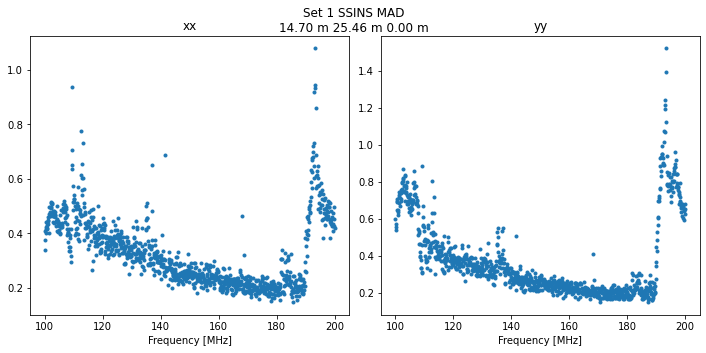

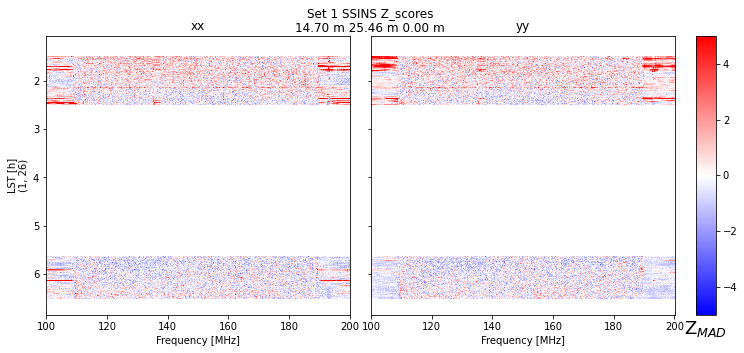

lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892324699567957 min. Keeping LST array stored from the first data set read.
Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


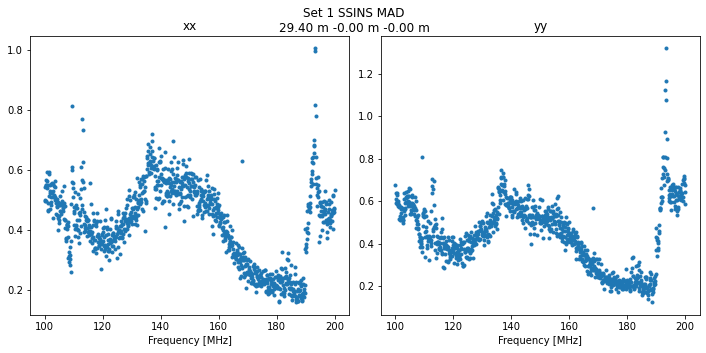

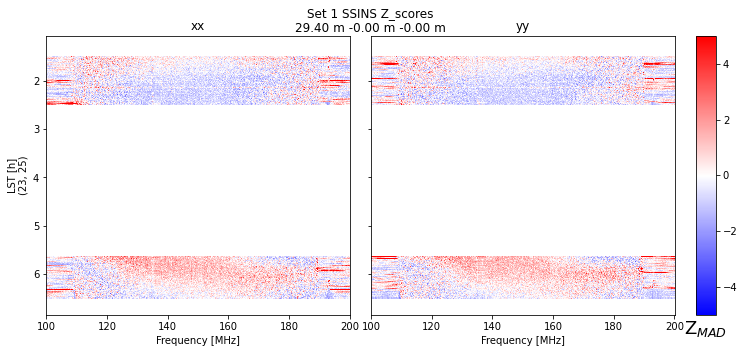

lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892324699567957 min. Keeping LST array stored from the first data set read.
Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


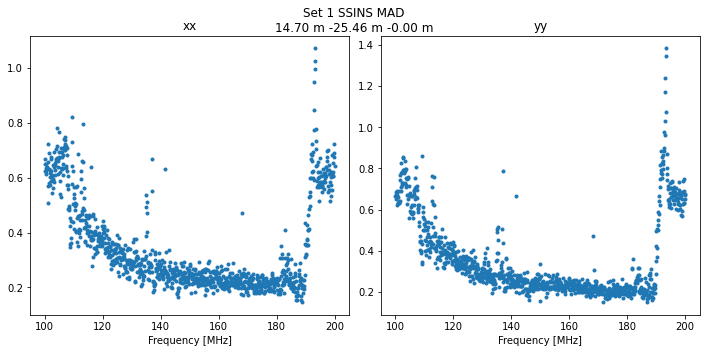

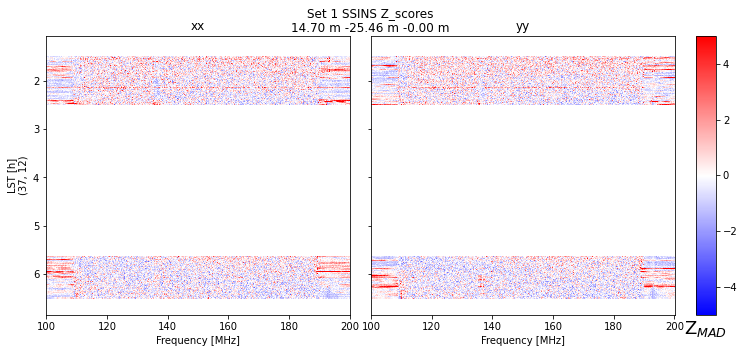

In [29]:
for gp in bl_cross:
    _uv = uv.select(bls=gp, inplace=False)
#     _uv.resample_in_time(target_time.to_value("s"), keep_ragged=False)
   
    _times = np.unique(_uv.time_array)
    if _times.size %2 == 1:
        _times = _times[:-1]

    __uv1 = _uv.select(times=_times[::2], inplace=False)
    __uv2 = _uv.select(times=_times[1::2], inplace=False)
    ds = DelaySpectrum([__uv1, __uv2], uvb=uvb, trcvr=50*units.K)
    
    bad_bls = [bl for bl_cnt, bl in enumerate(ds.baseline_array) if np.all(ds.flag_array[:, :, :, bl_cnt])]
    good_bls = list(set(ds.baseline_array) - set(bad_bls))

    ds.select(bls=good_bls, inplace=True)
    _uvw = r" ".join(f'{x:.2f}' for x in ds.uvw)

    ssins, mad = est_ssins(ds)
    
    fig, ax = plt.subplots(
        figsize=(12, 4 * 1 + 1),
        nrows=1,
        ncols=uv.Npols, 
        sharex=False,
        sharey=False,
        facecolor='white',
        squeeze=True,
    )
    norm = Normalize(vmin=0, vmax=5)
    fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
    fig.suptitle(
        f"Set 1 SSINS MAD\n{_uvw}"
    )
    for pol_cnt, pol in enumerate(uvutils.polnum2str(ds.polarization_array)):
        im = ax[pol_cnt].plot(
            ds.freq_array[0].to("MHz"),
            mad[0, pol_cnt, 0],
            ".",
        )
        ax[pol_cnt].set_xlabel(r"Frequency [MHz]")

        ax[pol_cnt].set_title(f"{pol}")

    fig, ax = plt.subplots(
        figsize=(12, 4 * 1 + 1),
        nrows=1,
        ncols=uv.Npols + 1, 
        sharex=False,
        sharey=False,
        facecolor='white',
        gridspec_kw={"width_ratios":[15] * uv.Npols + [1]},
        squeeze=True,
    )
    norm = Normalize(vmin=-5, vmax=5)
    fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
    fig.suptitle(
        f"Set 1 SSINS Z_scores\n{_uvw}"
    )
    ax[0].set_ylabel(
        f"LST [h]\n{tuple(uvutils.baseline_to_antnums(ds.baseline_array[0], ds.Nants_telescope))}"
    )
    for pol_cnt, pol in enumerate(uvutils.polnum2str(ds.polarization_array)):
        im = ax[pol_cnt].pcolormesh(
            ds.freq_array[0].to("MHz"),
            ds.lst_array.to("hourangle"),
            ssins[0, pol_cnt],
            norm=norm,
            cmap=plt.cm.bwr,
            shading="auto",
        )
        ax[pol_cnt].set_xlabel(r"Frequency [MHz]")

        ax[pol_cnt].set_title(f"{pol}")
        _ylim = ax[pol_cnt].get_ylim()
        ax[pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

        if  0 < pol_cnt < uv.Npols:
            plt.setp(ax[pol_cnt].get_yticklabels(), visible=False)
            ax[pol_cnt].set_ylabel("");
        else:
            ax

    cbar = fig.colorbar(im, cax=ax[-1], label=r"Z$_{MAD}$")#
    cbar.ax.set_xlabel(
        cbar.ax.get_ylabel(),
        fontsize=18,
    )
    cbar.ax.set_ylabel(None)
    plt.show()

In [30]:
ssins.max()

20.37828932798344

In [31]:
times = np.unique(uv.time_array)
if times.size %2 == 1:
    times = times[:-1]
    
_uv1 = uv.select(times=times[::2], inplace=False)
_uv2 = uv.select(times=times[1::2], inplace=False)

_uv1_noise = uv_noise.select(times=times[::2], inplace=False)
_uv2_noise = uv_noise.select(times=times[1::2], inplace=False)


if True:
    _uv1.resample_in_time(target_time.to_value("s"), keep_ragged=True, allow_drift=False)
    _uv2.resample_in_time(target_time.to_value("s"), keep_ragged=True, allow_drift=False)
    _uv1_noise.resample_in_time(target_time.to_value("s"), keep_ragged=True, allow_drift=False)
    _uv2_noise.resample_in_time(target_time.to_value("s"), keep_ragged=True, allow_drift=False)
# _uv1.downsample_in_time(n_times_to_avg=5, keep_ragged=False, allow_drift=False)
# _uv2.downsample_in_time(n_times_to_avg=5, keep_ragged=False, allow_drift=False)
# _uv1.downsample_in_time(n_times_to_avg=5, keep_ragged=False, allow_drift=False)
# _uv2.downsample_in_time(n_times_to_avg=5, keep_ragged=False, allow_drift=False)


_uv1.set_uvws_from_antenna_positions()
_uv2.set_uvws_from_antenna_positions()

_uv1_noise.set_uvws_from_antenna_positions()
_uv2_noise.set_uvws_from_antenna_positions()

The time difference between integrations is not the same as the integration time for baseline (1, 26). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 40). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 41). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 25). The output may average across longer time inter

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


The time difference between integrations is not the same as the integration time for baseline (1, 26). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 40). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 41). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 25). The output may average across longer time inter

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


The time difference between integrations is not the same as the integration time for baseline (1, 26). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 40). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 41). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 25). The output may average across longer time inter

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


The time difference between integrations is not the same as the integration time for baseline (1, 26). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 14). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (12, 39). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (13, 40). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (14, 41). The output may average across longer time intervals than expected
The time difference between integrations is not the same as the integration time for baseline (23, 25). The output may average across longer time inter

Data are in drift mode, phasing before resampling.
Unphasing back to drift mode.


In [32]:
uv1 = _uv1.select(bls=bl_cross[0], inplace=False)
uv2 = _uv2.select(bls=bl_cross[0], inplace=False)
uv1_noise  = _uv1_noise.select(bls=bl_cross[0], inplace=False)
uv2_noise  = _uv2_noise.select(bls=bl_cross[0], inplace=False)

ds = DelaySpectrum(uv=[uv1, uv2])

ds.add_uvbeam(uvb)
ds.cosmology = Planck15
# ds.set_taper(windows.boxcar)

#manually insert noise simulation
for bl_cnt, bl in enumerate(ds.baseline_array):
    ds.noise_array[0, :, :, bl_cnt] = np.stack([uv1_noise.get_data(bl), uv2_noise.get_data(bl)]).transpose([0, 3, 1, 2]) * units.Jy

lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892318805636 min. Keeping LST array stored from the first data set read.


In [33]:
uv1 = _uv1.select(bls=bl_cross[1], inplace=False)
uv2 = _uv2.select(bls=bl_cross[1], inplace=False)
uv1_noise  = _uv1_noise.select(bls=bl_cross[1], inplace=False)
uv2_noise  = _uv2_noise.select(bls=bl_cross[1], inplace=False)

ds2 = DelaySpectrum(uv=[uv1, uv2])
ds2.add_uvbeam(uvb)
ds2.cosmology = Planck15

#manually insert the noise simulation
for bl_cnt, bl in enumerate(ds2.baseline_array):
    ds2.noise_array[0, :, :, bl_cnt] = np.stack([uv1_noise.get_data(bl), uv2_noise.get_data(bl)]).transpose([0, 3, 1, 2])  * units.Jy


uv1 = _uv1.select(bls=bl_cross[2], inplace=False)
uv2 = _uv2.select(bls=bl_cross[2],  inplace=False)
uv1_noise  = _uv1_noise.select(bls=bl_cross[2], inplace=False)
uv2_noise  = _uv2_noise.select(bls=bl_cross[2], inplace=False)

ds3 = DelaySpectrum(uv=[uv1, uv2])
ds3.add_uvbeam(uvb)
ds3.cosmology = Planck15

#manually insert the noise simulation
for bl_cnt, bl in enumerate(ds3.baseline_array):
    ds3.noise_array[0, :, :, bl_cnt] = np.stack([uv1_noise.get_data(bl), uv2_noise.get_data(bl)]).transpose([0, 3, 1, 2])  * units.Jy


lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892318805636 min. Keeping LST array stored from the first data set read.


lst_array parameter value is array, values are not close


Input LST arrays differ on average by 0.35892318805636 min. Keeping LST array stored from the first data set read.


In [34]:
ds_list = [ds, ds2, ds3]
for _d in ds_list:
    _d.set_taper(taper)
    _d.add_trcvr(trcvr)
    bad_bls = [bl for bl_cnt, bl in enumerate(_d.baseline_array) if np.all(_d.flag_array[:, :, :, bl_cnt])]
    if( bl83 := uvutils.antnums_to_baseline(83,85, _d.Nants_telescope)) in _d.baseline_array:
        bad_bls += [bl83]
    good_bls = list(set(_d.baseline_array) - set(bad_bls))
    print(f"{_d.uvw} removing {bad_bls}")
    _d.select(bls=good_bls, inplace=True)
#     _d.data_array -= np.ma.masked_array(
#         _d.data_array.value,
#         mask=_d.flag_array,
#     ).mean(4, keepdims=True) * _d.data_array.unit

[1.47000004e+01 2.54611467e+01 3.55302554e-07] m removing [96298]
[ 2.94000000e+01 -4.53004047e-07 -7.62293234e-07] m removing [92175, 237654]
[ 1.46999996e+01 -2.54611471e+01 -1.11763421e-06] m removing [147471]


Input baseline array is a mix of integers and tuples of integers. Assuming all integers not in a tuple as baseline numbers and converting to antenna pairs.


In [35]:
fft_freq = lambda x: np.fft.fftshift(np.fft.fft(x * ds.taper(x.shape[1]).reshape(1,-1), axis=1), axes=1)
fft_fringe = lambda x: np.fft.fftshift(np.fft.fft(x * ds.taper(x.shape[0]).reshape(-1,1), axis=0), axes=0)
fringe_rates = (np.fft.fftshift(np.fft.fftfreq(ds.Ntimes, d=np.diff(ds.lst_array.to('hourangle'))[0].value) )/units.hour).to('mHz')

#### **The Data**

FixedFormatter should only be used together with FixedLocator


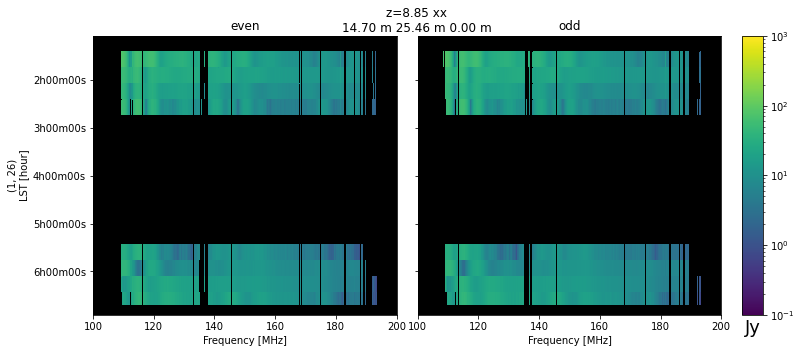

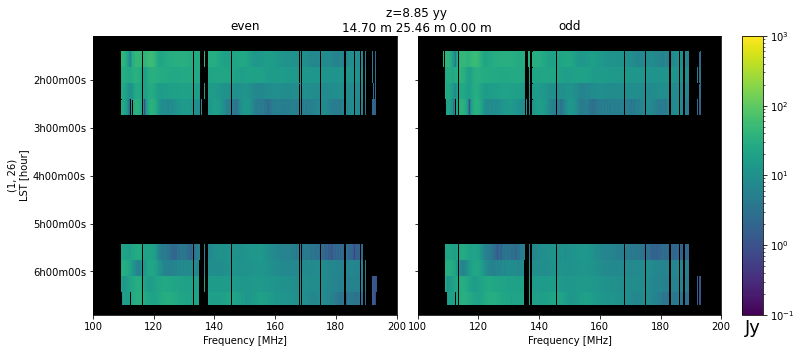

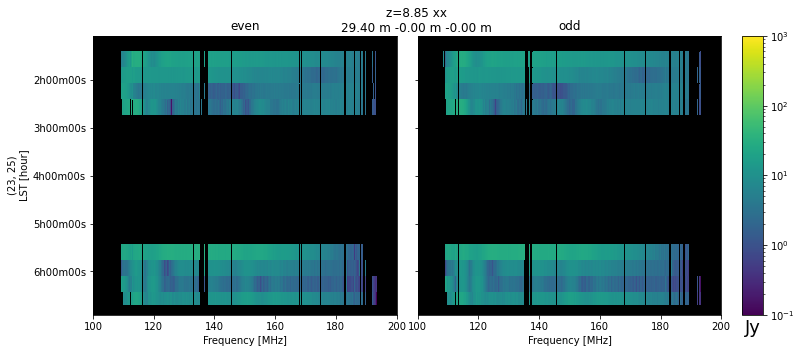

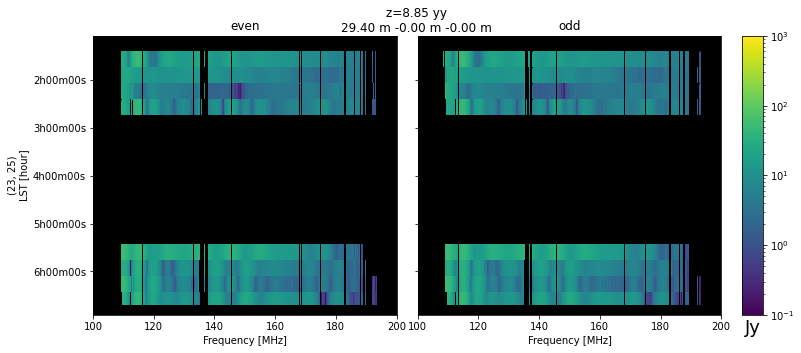

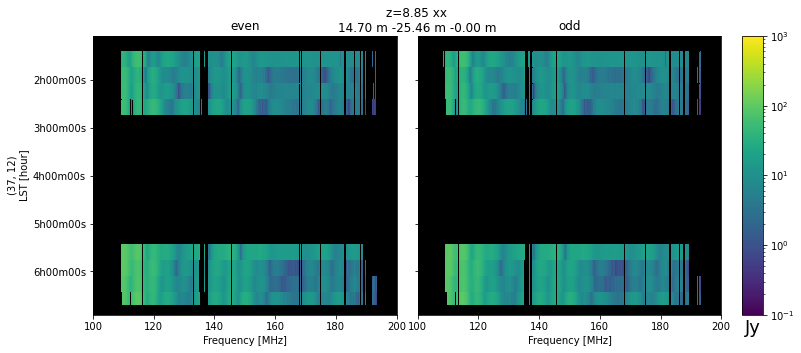

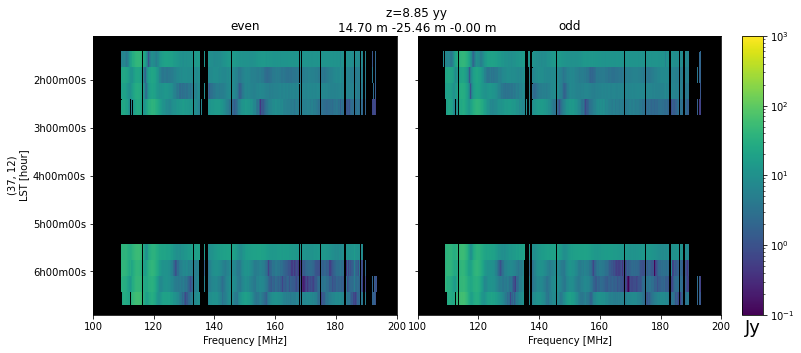

In [36]:
vmin = -5
vmax = 5
norm = LogNorm(vmin=1e-1, vmax=1e3)
for _d in ds_list:
    _uvw = r" ".join(f'{x:.2f}' for x in _d.uvw)
    for pol_cnt, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
        ncols = _d.Nuv + 1
#         nrows = _d.Nbls - np.all(_d.flag_array, axis=(0,1,2,4,5)).sum()
        nrows = 1 
        fig, ax = plt.subplots(
                figsize=(12, 4 * nrows + 1),
                nrows=nrows,
                ncols=ncols, 
                sharex=False,
                sharey=False,
                facecolor='white',
                gridspec_kw={"width_ratios":[15] * ds.Nuv + [1]},
                squeeze=False,
                )
        fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
        fig.suptitle(
            f"z={_d.redshift.item(0):.2f} "
            f"{pol}\n{_uvw}"
        )
        bl_cnt = 0
        for bl_ind, bl in enumerate(_d.baseline_array):

            if np.all(_d.flag_array[:, :, :, bl_ind]):
                continue
            sharedy = ax[bl_cnt, 0].get_shared_y_axes()
            sharedx = ax[bl_cnt, 0].get_shared_x_axes()

            ax[bl_cnt, 0].set_ylabel(
                f"{uvutils.baseline_to_antnums(bl, _d.Nants_telescope)}\n"
                "LST [hour]"
            )
            for day_cnt, day in enumerate(["even", "odd"]):

                ax[bl_cnt, day_cnt].set_xlabel(r"Frequency [MHz]")
                sharedx.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])
                sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])

                masked_data = np.ma.masked_array(
                    _d.data_array[0, day_cnt, pol_cnt, bl_ind].value,
                    mask=_d.flag_array[0, day_cnt, pol_cnt, bl_ind]
                )

                im = ax[bl_cnt, day_cnt].pcolormesh(
                    _d.freq_array[0].to('MHz'),
                    _d.lst_array.to("hourangle"),
                    np.abs(masked_data),
                    cmap=cmap,
                    norm=norm,
                    shading="auto",
                )

                ax[bl_cnt, day_cnt].set_title(f"{day}")
                _ylim = ax[bl_cnt, day_cnt].get_ylim()
                ax[bl_cnt, day_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])


                tick_labels =  ax[bl_cnt, day_cnt].get_yticks()
                tick_labels = [Angle(t*units.hourangle).to_string() for t in tick_labels]
                ax[bl_cnt, day_cnt].set_yticklabels(tick_labels);

                if  0 < day_cnt < ncols - 1:
                    plt.setp(ax[bl_cnt, day_cnt].get_yticklabels(), visible=False)
                    ax[bl_cnt, day_cnt].set_ylabel("")
                


            cbar = fig.colorbar(im, cax=ax[bl_cnt, -1], label="Jy")#
            cbar.ax.set_xlabel(
                cbar.ax.get_ylabel(),
                fontsize=18,
            )
            cbar.ax.set_ylabel(None)
            bl_cnt += 1
            break
                
        
plt.show()

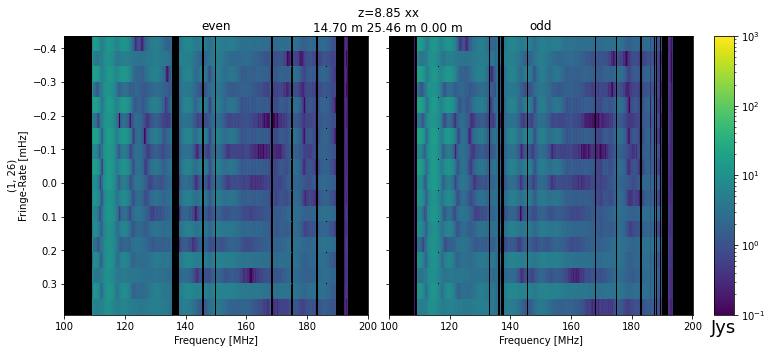

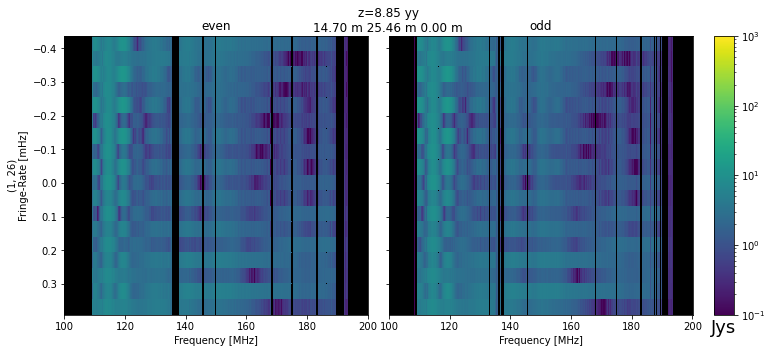

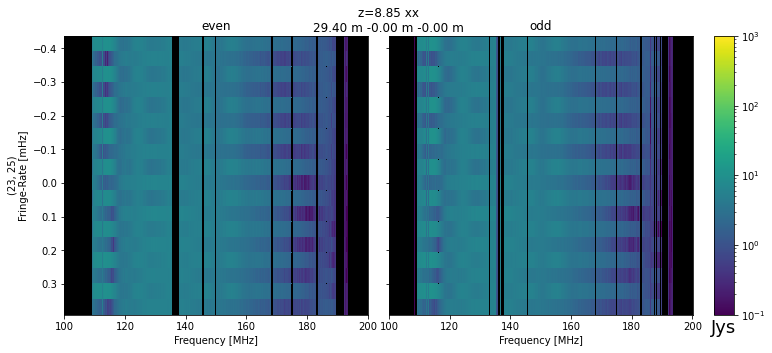

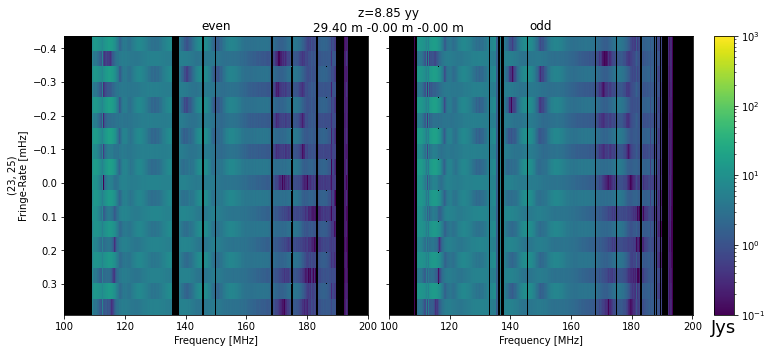

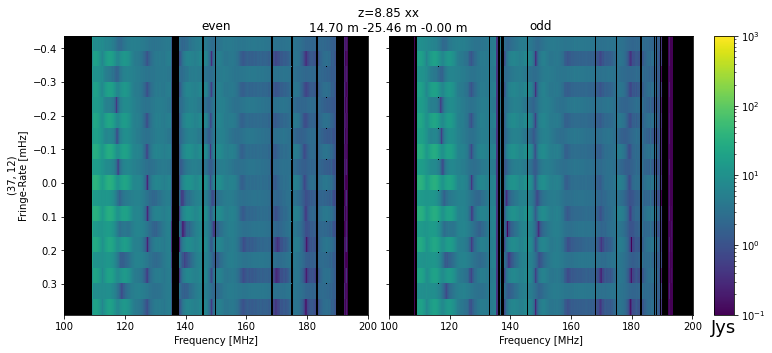

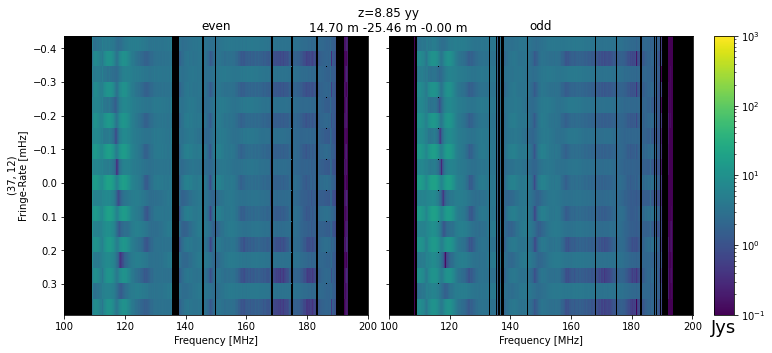

In [37]:
vmin = -5
vmax = 5
norm = LogNorm(vmin=1e-1, vmax=1e3)
for _d in ds_list:
    _uvw = r" ".join(f'{x:.2f}' for x in _d.uvw)
    
    for pol_cnt, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
        ncols = _d.Nuv + 1
#         nrows = _d.Nbls - np.all(_d.flag_array, axis=(0,1,2,4,5)).sum()
        nrows = 1
        fig, ax = plt.subplots(
                figsize=(12, 4 * nrows + 1),
                nrows=nrows,
                ncols=ncols, 
                sharex=False,
                sharey=False,
                facecolor='white',
                gridspec_kw={"width_ratios":[15] * ds.Nuv + [1]},
                squeeze=False,
                )
        fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
        fig.suptitle(
            f"z={_d.redshift.item(0):.2f} "
            f"{pol}\n"
            f"{_uvw}"
        )
        bl_cnt = 0
        for bl_ind, bl in enumerate(_d.baseline_array):

            if np.all(_d.flag_array[:, :, :, bl_ind]):
                continue
            sharedy = ax[bl_cnt, 0].get_shared_y_axes()
            sharedx = ax[bl_cnt, 0].get_shared_x_axes()

            ax[bl_cnt, 0].set_ylabel(
                f"{uvutils.baseline_to_antnums(bl, _d.Nants_telescope)}\n"
                "Fringe-Rate [mHz]"
            )
            for day_cnt, day in enumerate(["even", "odd"]):

                ax[bl_cnt, day_cnt].set_xlabel(r"Frequency [MHz]")
                sharedx.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])
                sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])

                masked_data = np.ma.masked_array(
                    _d.data_array[0, day_cnt, pol_cnt, bl_ind].value,
                    mask=_d.flag_array[0, day_cnt, pol_cnt, bl_ind]
                )

                im = ax[bl_cnt, day_cnt].pcolormesh(
                    _d.freq_array[0].to('MHz'),
                    fringe_rates,
                    np.abs(fft_fringe(masked_data.filled(0))),
                    cmap=cmap,
                    norm=norm,
                    shading="auto",
                )

                ax[bl_cnt, day_cnt].set_title(f"{day}")
                _ylim = ax[bl_cnt, day_cnt].get_ylim()
                ax[bl_cnt, day_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

                if  0 < day_cnt < ncols - 1:
                    plt.setp(ax[bl_cnt, day_cnt].get_yticklabels(), visible=False)
                    ax[bl_cnt, day_cnt].set_ylabel("")
                


            cbar = fig.colorbar(im, cax=ax[bl_cnt, -1], label="Jys")#
            cbar.ax.set_xlabel(
                cbar.ax.get_ylabel(),
                fontsize=18,
            )
            cbar.ax.set_ylabel(None)
            bl_cnt += 1
            break
                
        
plt.show()

In [38]:
for _d in ds_list:
    _d.select_spectral_windows(spws)
    _d.check()                       

FixedFormatter should only be used together with FixedLocator


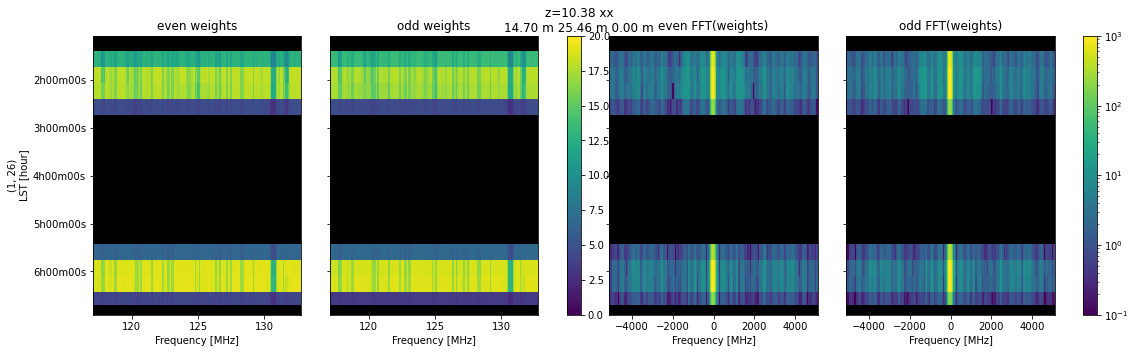

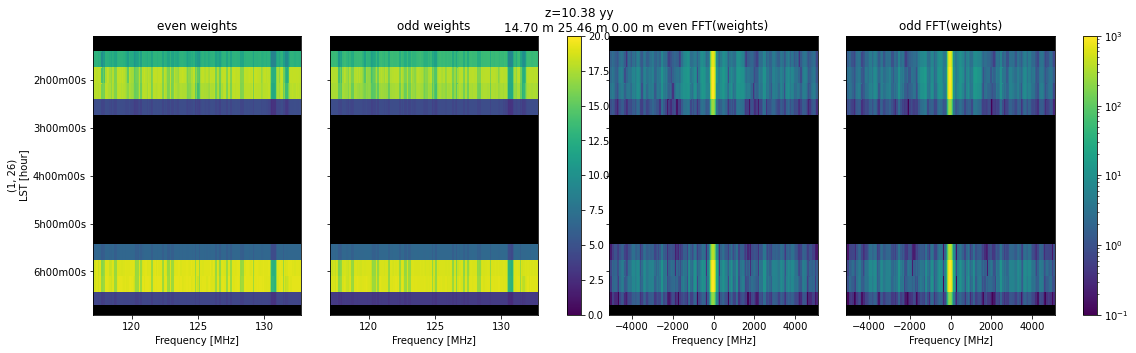

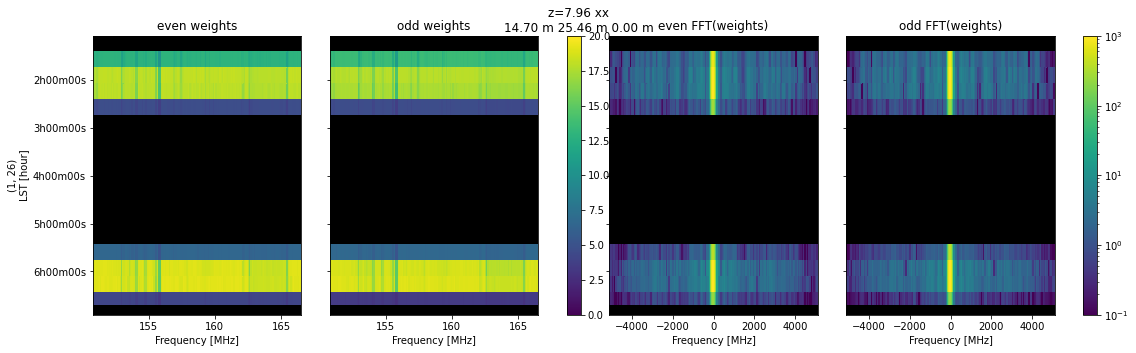

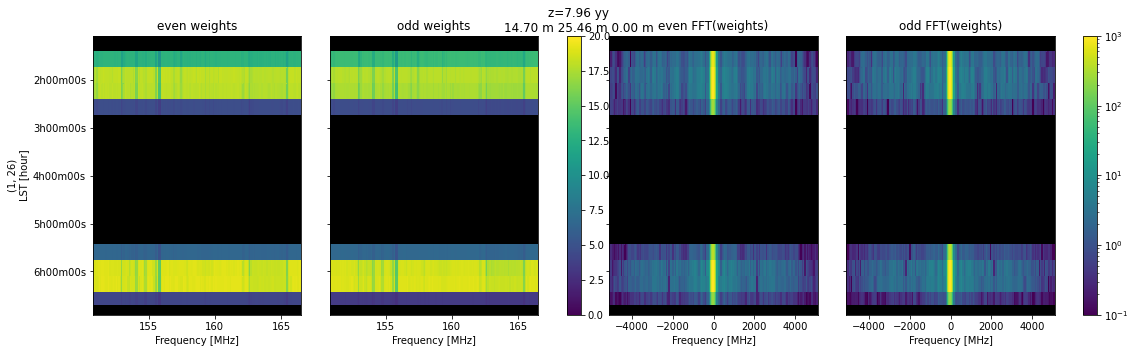

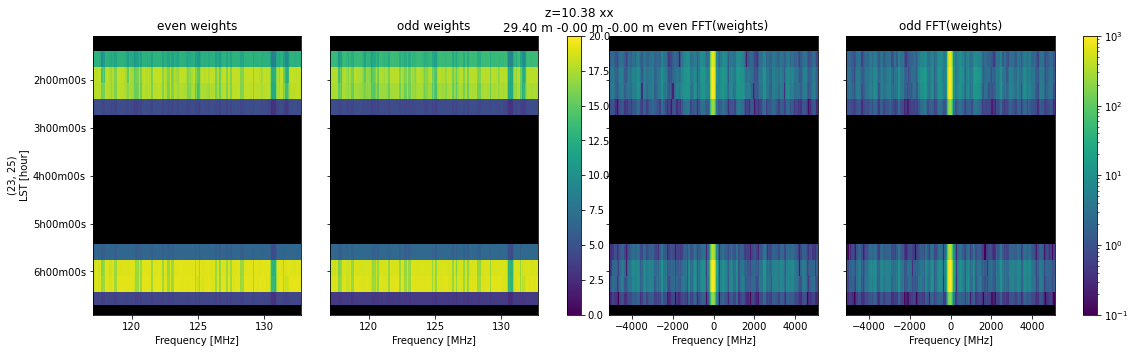

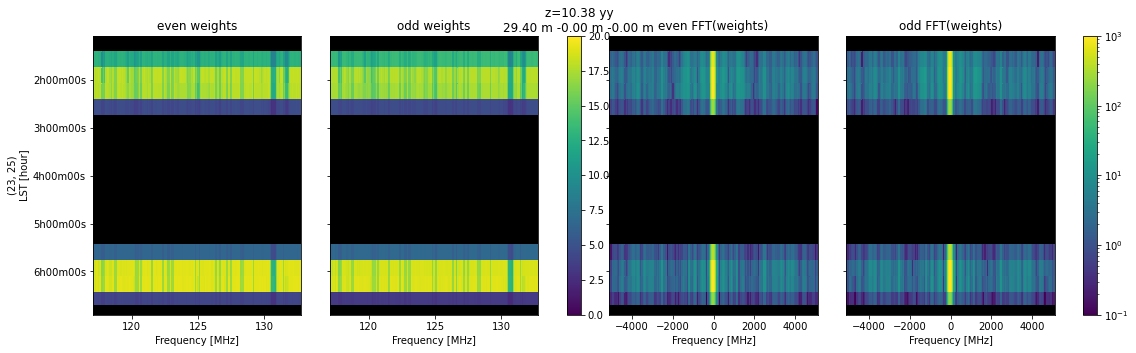

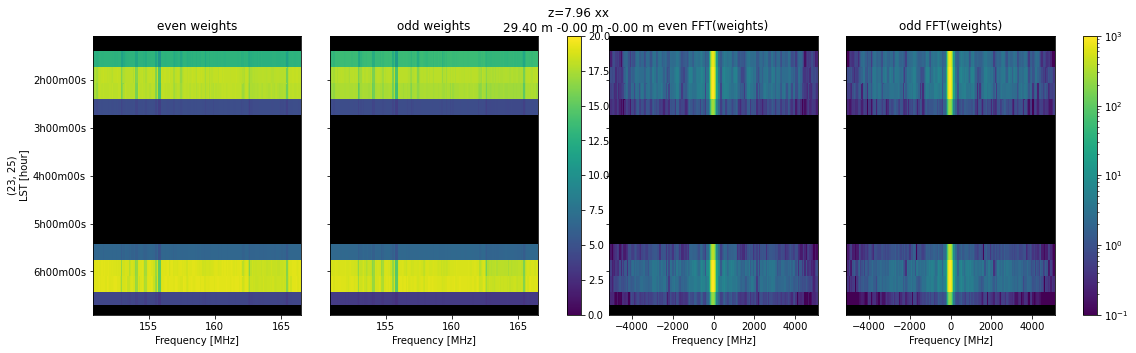

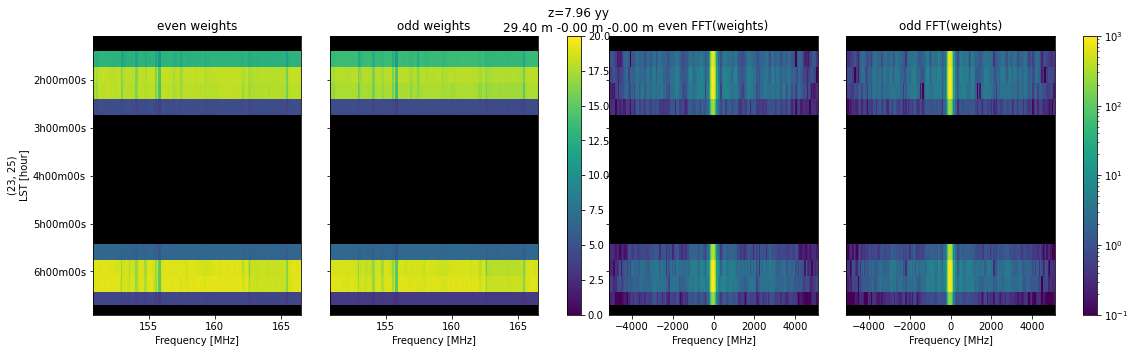

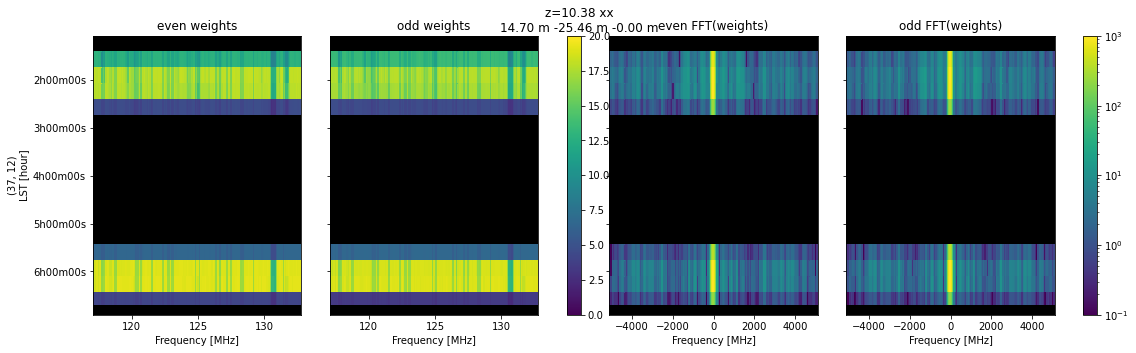

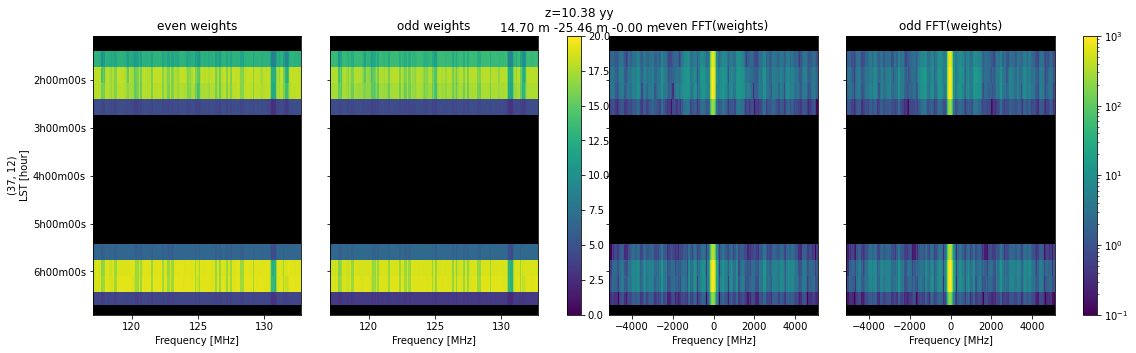

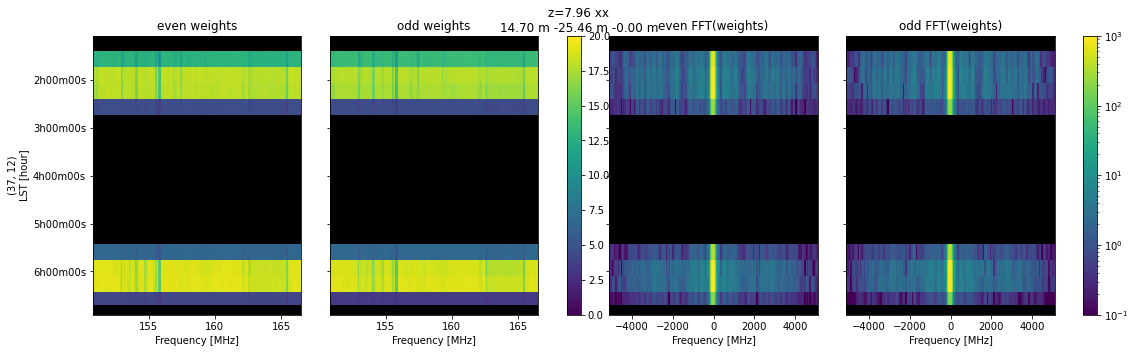

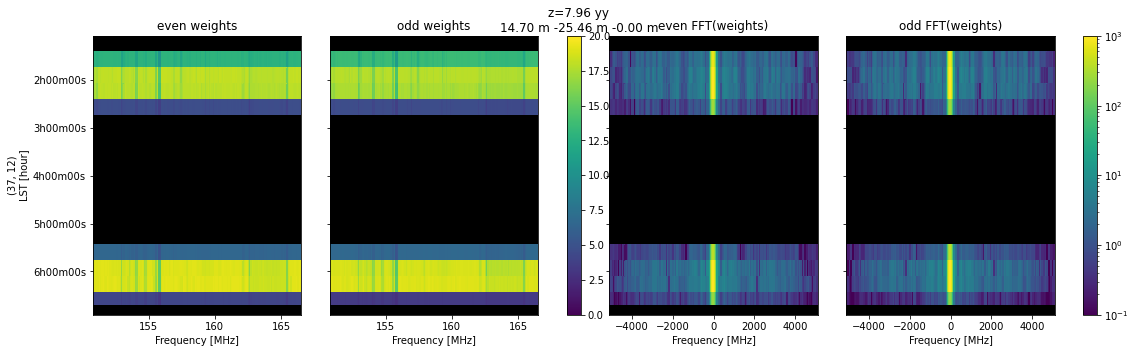

In [39]:
vmin = -5
vmax = 5
norm = Normalize(vmin=0, vmax=20)
norm1 = LogNorm(vmin=1e-1, vmax=1e3)
for _d in ds_list:
    for z_cnt, z in enumerate(_d.redshift):
        _uvw = r" ".join(f'{x:.2f}' for x in _d.uvw)
        for pol_cnt, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
            ncols = 2 * _d.Nuv + 2
#             nrows = _d.Nbls - np.all(_d.flag_array, axis=(0,1,2,4,5)).sum()
            nrows = 1
            fig, ax = plt.subplots(
                    figsize=(18, 4 * nrows + 1),
                    nrows=nrows,
                    ncols=ncols, 
                    sharex=False,
                    sharey=False,
                    facecolor='white',
                    gridspec_kw={"width_ratios":([15] * ds.Nuv + [1]) * 2},
                    squeeze=False,
                    )
            fig.subplots_adjust(hspace=.35, wspace=0.2, top=.9)
            fig.suptitle(
                f"z={z:.2f} "
                f"{pol}\n{_uvw}"
            )
            bl_cnt = 0
            for bl_ind, bl in enumerate(_d.baseline_array):

                if np.all(_d.flag_array[:, :, :, bl_ind]):
                    continue
                sharedy = ax[bl_cnt, 0].get_shared_y_axes()
                sharedx = ax[bl_cnt, 0].get_shared_x_axes()
                sharedx2 = ax[bl_cnt, 2].get_shared_x_axes()

                ax[bl_cnt, 0].set_ylabel(
                    f"{uvutils.baseline_to_antnums(bl, _d.Nants_telescope)}\n"
                    "LST [hour]"
                )
                for day_cnt, day in enumerate(["even", "odd"]):

                    ax[bl_cnt, day_cnt].set_xlabel(r"Frequency [MHz]")
                    ax[bl_cnt, day_cnt + 3].set_xlabel(r"Frequency [MHz]")

                    sharedx.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])
                    sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt])

                    sharedy.join(ax[bl_cnt, 0], ax[bl_cnt, day_cnt + 3])

                    sharedx2.join(ax[bl_cnt, 3], ax[bl_cnt, day_cnt + 3])

                    masked_data = np.ma.masked_array(
                        _d.nsample_array[z_cnt, day_cnt, pol_cnt, bl_ind],
                        mask=_d.flag_array[z_cnt, day_cnt, pol_cnt, bl_ind]
                    )

                    im = ax[bl_cnt, day_cnt].pcolormesh(
                        _d.freq_array[z_cnt].to('MHz'),
                        _d.lst_array.to("hourangle"),
                        np.abs(masked_data),
                        cmap=cmap,
                        norm=norm,
                        shading="auto",
                    )
                    im1 = ax[bl_cnt, day_cnt + 3].pcolormesh(
                        _d.delay_array.to('ns'),
                        _d.lst_array.to("hourangle"),
                        np.abs(fft_freq(masked_data.filled(0))),
                        cmap=cmap,
                        norm=norm1,
                        shading="auto",
                    )

                    ax[bl_cnt, day_cnt].set_title(f"{day} weights")
                    ax[bl_cnt, day_cnt + 3].set_title(f"{day} FFT(weights)")
                    _ylim = ax[bl_cnt, day_cnt].get_ylim()
                    ax[bl_cnt, day_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])


                    tick_labels =  ax[bl_cnt, day_cnt].get_yticks()
                    tick_labels = [Angle(t*units.hourangle).to_string() for t in tick_labels]
                    ax[bl_cnt, day_cnt].set_yticklabels(tick_labels);

                    if  0 < day_cnt < ncols - 1:
                        plt.setp(ax[bl_cnt, day_cnt].get_yticklabels(), visible=False)
                        ax[bl_cnt, day_cnt].set_ylabel("")
                    plt.setp(ax[bl_cnt, day_cnt + 3].get_yticklabels(), visible=False)
                    ax[bl_cnt, day_cnt + 3].set_ylabel("")



                cbar = fig.colorbar(im, cax=ax[bl_cnt, 2], label="")#
                cbar.ax.set_xlabel(
                    cbar.ax.get_ylabel(),
                    fontsize=18,
                )
                cbar.ax.set_ylabel(None)

                cbar = fig.colorbar(im1, cax=ax[bl_cnt, -1], label="")#
                cbar.ax.set_xlabel(
                    cbar.ax.get_ylabel(),
                    fontsize=18,
                )

                cbar.ax.set_ylabel(None)
                bl_cnt += 1
                break

        
plt.show()

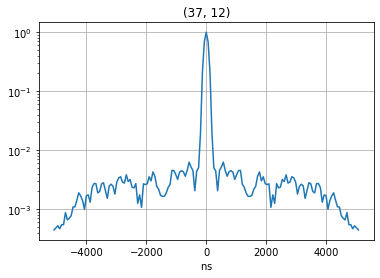

In [40]:
fig, ax = plt.subplots(1, facecolor="white")

masked_data = np.ma.masked_array(
    _d.nsample_array[-1, day_cnt, pol_cnt, bl_ind],
    mask=_d.flag_array[-1, day_cnt, pol_cnt, bl_ind]
)
delay_data = fft_freq(masked_data.filled(0))
delay_data = np.ma.masked_array(delay_data)
delay_data.mask = np.all(delay_data ==0, axis=0, keepdims=True)
ax.plot(
    _d.delay_array.to('ns'),
    np.abs(delay_data).mean(0)/np.abs(delay_data).mean(0).max(),
)
ax.set_title(uvutils.baseline_to_antnums(_d.baseline_array[bl_ind], _d.Nants_telescope))
ax.set_yscale("log");
ax.grid();

In [41]:
for cnt, _d in enumerate(ds_list):
    _d.delay_transform()
    _d.calculate_delay_spectrum(littleh_units=True)
    

In [42]:
ncols = np.int(np.ceil(np.sqrt(ds.Npols)))
nrows = np.int(np.ceil(ds.Npols/float(ncols)))

#### **The Power Spectrum** 

In power spectrum space the data again looks noise-like in amplitude, this is consistent with the fourier transform of a flat spectrum input.

FixedFormatter should only be used together with FixedLocator


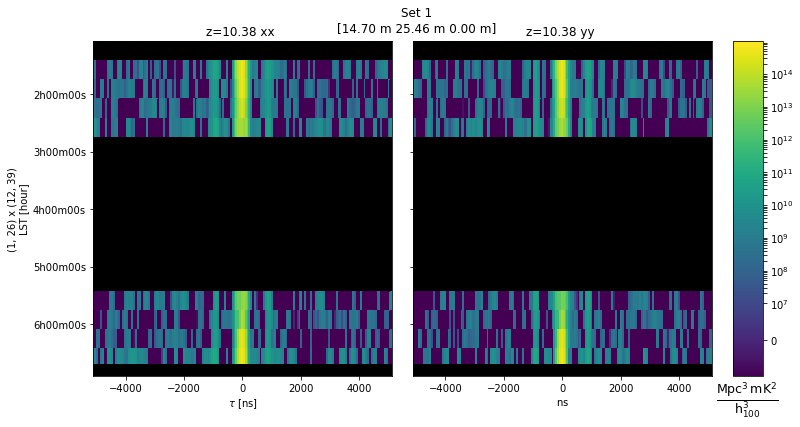

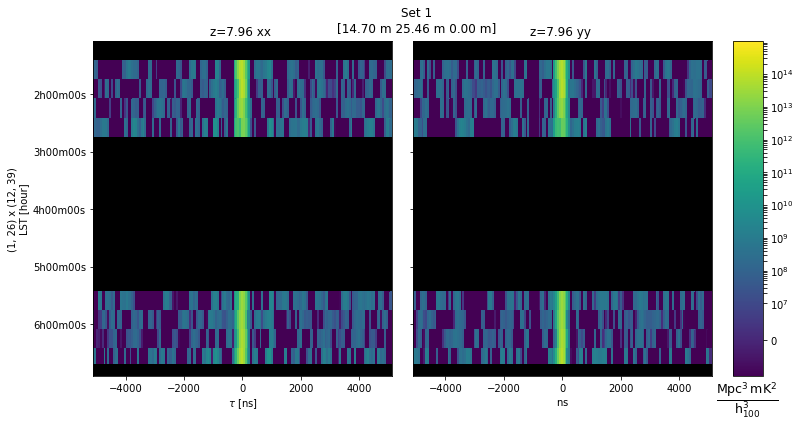

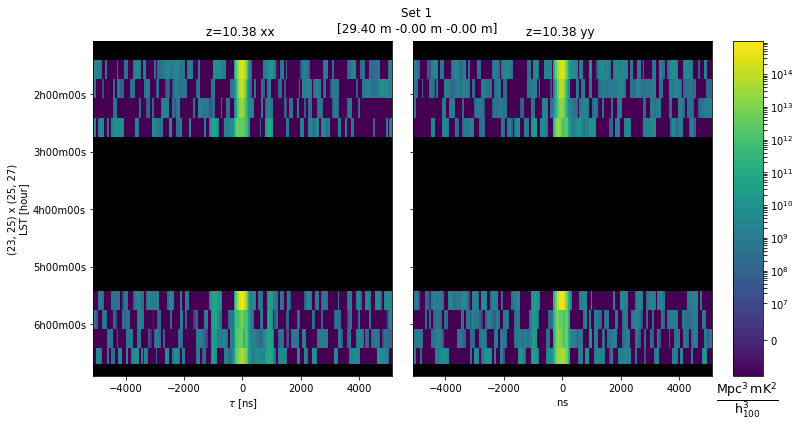

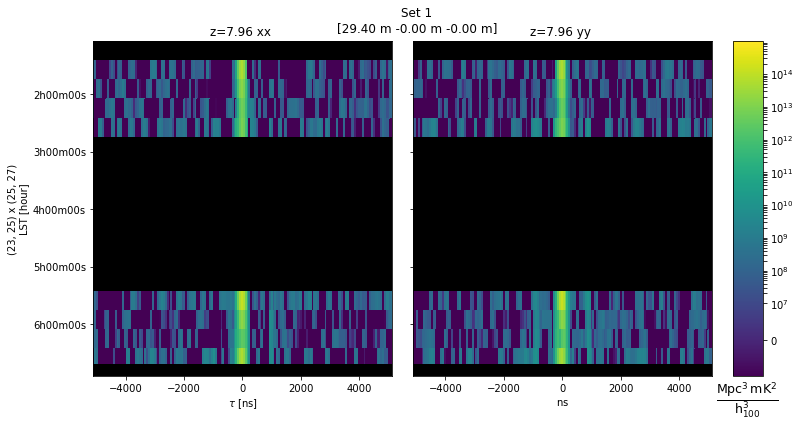

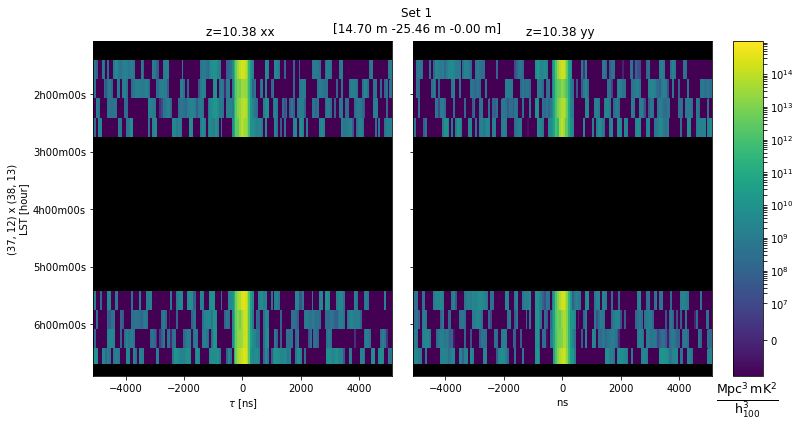

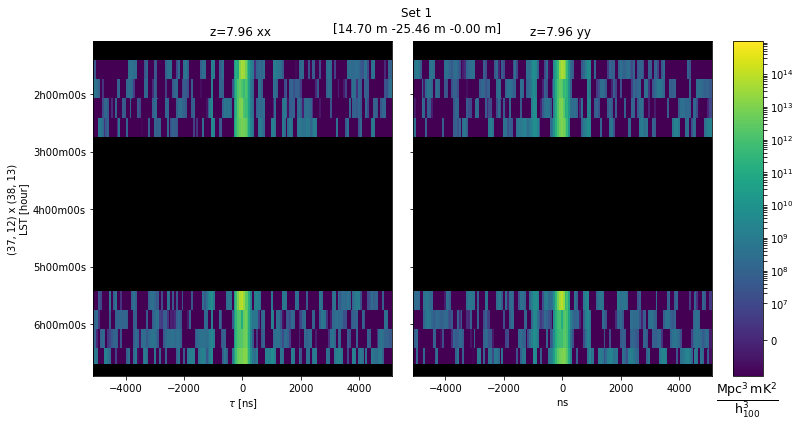

In [43]:
norm = SymLogNorm(vmin=-1e7, linthresh=1e7, vmax=1e15, base=10)
for _d in ds_list:
    _uvw = "[" + r" ".join(f'{x:.2f}' for x in _d.uvw) + "]"
    
    for z_cnt, z in enumerate(_d.redshift):
        ncols = _d.Npols + 1
#         nrows = _d.Nbls**2 - np.logical_or(np.all(_d.flag_array, axis=(0, 1, 2, 4, 5)), np.all(_d.power_array == 0, axis=(0,1,4,5))).sum()
        nrows = 1 
        fig, ax = plt.subplots(
            figsize=(12, 5 * nrows + 1),
            nrows=nrows,
            ncols=ncols, 
            sharex=False,
            sharey=False,
            facecolor='white',
            squeeze=False,
            gridspec_kw={"width_ratios":[10] * _d.Npols + [1]},
            )
        fig.subplots_adjust(hspace=.35, wspace=0.1, top=.9)
        fig.suptitle(f"Set 1\n{_uvw}")
    #         fig.suptitle(f"{np.around(np.linalg.norm(_d.uvw.value),1)} {day:s}")
        fig_count = 0
        for bl_cnt, bl in enumerate(_d.baseline_array):
            for bl_cnt2, bl2 in enumerate(_d.baseline_array):

                if np.all(_d.flag_array[:, :, :, bl_cnt]) or np.all(_d.flag_array[:, :, :, bl_cnt2]) or np.all(_d.power_array[:,:,bl_cnt, bl_cnt2] == 0) or bl == bl2:
                    continue
                sharedy = ax[fig_count,0].get_shared_y_axes()

                sharedx = ax[fig_count,0].get_shared_x_axes()

                ax[fig_count, 0].set_ylabel(
                    f"{uvutils.baseline_to_antnums(bl, _d.Nants_telescope)} x {uvutils.baseline_to_antnums(bl2, _d.Nants_telescope)}\n"
                    "LST [hour]"
                )

                ax[fig_count, 0].set_xlabel(r"$\tau$ [ns]")
                for pol_cnt, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
                    sharedy.join(ax[fig_count,0], ax[fig_count, pol_cnt])
                    sharedx.join(ax[fig_count,0], ax[fig_count, pol_cnt])
                    masked_data = np.ma.masked_invalid(
                        _d.power_array[z_cnt, pol_cnt, bl_cnt, bl_cnt2].value,
    #                     mask=_d.flag_array[z_cnt, pol_cnt, 0, 0],
                    )
                    masked_data.mask |= np.all(masked_data ==0, axis=-1, keepdims=True)

                    im = ax[fig_count, pol_cnt].pcolormesh(
                        _d.delay_array.to('ns'),
                        _d.lst_array.to('hourangle'),
                        np.real(masked_data),
                        cmap=cmap,
                        norm=norm,
                        shading="auto",
                    )

                    ax[fig_count, pol_cnt].set_title(
                        f"z={z:.2f} "
                        f"{uvutils.polnum2str(_d.polarization_array[pol_cnt])} "
                    )
                    _ylim = ax[fig_count, pol_cnt].get_ylim()
                    ax[fig_count, pol_cnt].set_ylim([np.max(_ylim), np.min(_ylim)])

                    tick_labels =  ax[fig_count, pol_cnt].get_yticks()
                    tick_labels = [Angle(t*units.hourangle).to_string() for t in tick_labels]
                    ax[fig_count, pol_cnt].set_yticklabels(tick_labels);
                    if  0 < pol_cnt < ncols - 1:
                        plt.setp(ax[fig_count, pol_cnt].get_yticklabels(), visible=False)
                        ax[fig_count, pol_cnt].set_ylabel("")

                cbar = fig.colorbar(im, cax=ax[fig_count, -1], label=_d.power_array.unit.to_string("latex"))#
                cbar.ax.set_xlabel(
                    cbar.ax.get_ylabel(),
                    fontsize=18,
                )
                cbar.ax.set_ylabel(None)
                fig_count += 1
                if nrows == 1:
                    break
            if nrows == 1:
                break


In [44]:
ncols = np.int(np.ceil(np.sqrt(ds.Npols)))
nrows = np.int(np.ceil(ds.Npols/float(ncols)))

In [45]:
values = np.zeros(
    (
        len(ds_list),
        np.max([_d.Nspws for _d in ds_list]),
        np.max([_d.Npols for _d in ds_list]),
        ds_list[0].Ntimes,
        ds_list[0].Ndelays,
    ), 
    dtype=np.complex128
) * _d.power_array.unit

errors = np.zeros_like(values)
noise_values = np.zeros_like(values)
noise_errors = np.zeros_like(values)
thermal_estimates = np.zeros(
     (
        len(ds_list),
        np.max([_d.Nspws for _d in ds_list]),
        np.max([_d.Npols for _d in ds_list]),
        ds_list[0].Ntimes,
    )
) * _d.power_array.unit
pn_sim = np.zeros_like(values)

for cnt, _d in enumerate(ds_list):
    # get thermal, power, and noise averaged over baseline dimension
    thermals = utils.remove_auto_correlations(_d.thermal_power, axes=(2, 3))
    thermals = np.ma.masked_invalid(thermals.value)
    # make sure any row of all zeros is masked
    thermals.mask |= np.all(thermals.data == 0, axis=2, keepdims=True)
    
    # unweighted average over bls
    # thermals are an estimate of uncertainty, average in quadrature
#     t1 = thermals.mean()
    _, thermals = utils.weighted_average(np.ones_like(thermals), thermals, axis=2)
#     thermals = thermals**2
#     thermals = np.sqrt(np.ma.sum(thermals, axis=2)/thermals.shape[2]**2)
#     t2 = thermals.mean()
#     print(t1, t2, t1/t2, np.sqrt(_d.Nbls * (_d.Nbls - 1)))
    
    thermal_estimates[cnt] = thermals * _d.thermal_power.unit
    
    # Power spcetrum values
    powers = utils.remove_auto_correlations(_d.power_array.value, axes=(2, 3))
    powers  = np.ma.masked_invalid(powers)
    # make sure any row of all zeros is masked
    powers.mask |= np.all(powers.data == 0, axis=3, keepdims=True)
    errs = utils.bootstrap_array(powers, axis=2).mean(2)
    
    errs = (errs.real.std(2).data + 1j * errs.imag.std(2).data) * _d.power_array.unit
    
    values[cnt] = powers.mean(2).data * _d.power_array.unit
    errors[cnt] = errs 
    
    # Noise simulation
    noise_powers = utils.remove_auto_correlations(_d.noise_power.value, axes=(2, 3))
    noise_powers  = np.ma.masked_invalid(noise_powers)
    # make sure any row of all zeros is masked
    noise_powers.mask |= np.all(noise_powers.data == 0, axis=3, keepdims=True)
    
    noise_errs = utils.bootstrap_array(noise_powers, axis=2).mean(2)
    noise_errs =( noise_errs.real.std(2).data + 1j * noise_errs.imag.std(2).data) * _d.power_array.unit
    
    noise_values[cnt] = noise_powers.mean(2).data * _d.power_array.unit
    noise_errors[cnt] = noise_errs
    
    _pn_sim, _ = np.array(
        utils.weighted_average(noise_errs.real.value.copy(), noise_errs.value.real.copy(), weights=np.ones_like(noise_errs.real), axis=-1)
    ) + 1j * np.array(
        utils.weighted_average(noise_errs.imag.value.copy(), noise_errs.value.imag.copy(), weights=np.ones_like(noise_errs.imag), axis=-1)
    )
    
    _pn_sim = np.tile(
        _pn_sim,
        (noise_errs.shape[-1], 1, 1, 1),
    ).transpose([1, 2, 3, 0]) * _d.power_array.unit

    pn_sim[cnt] = _pn_sim
    

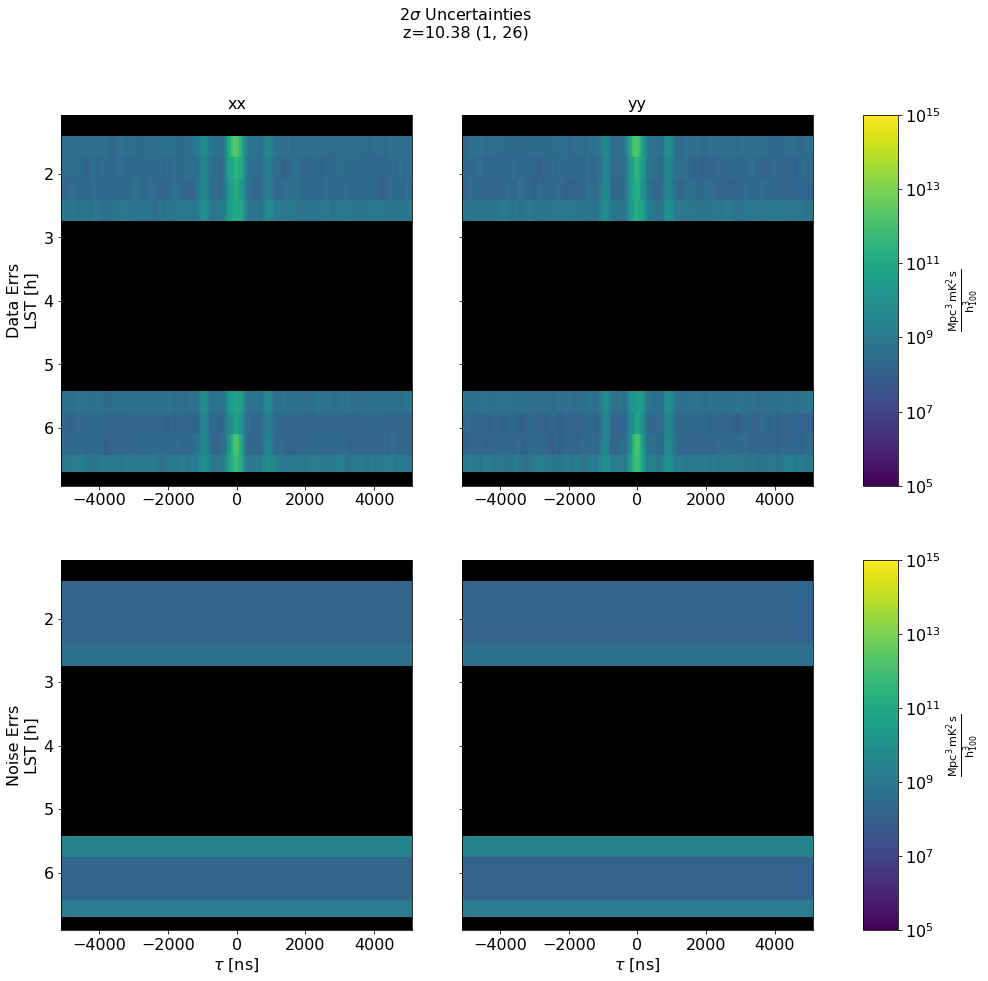

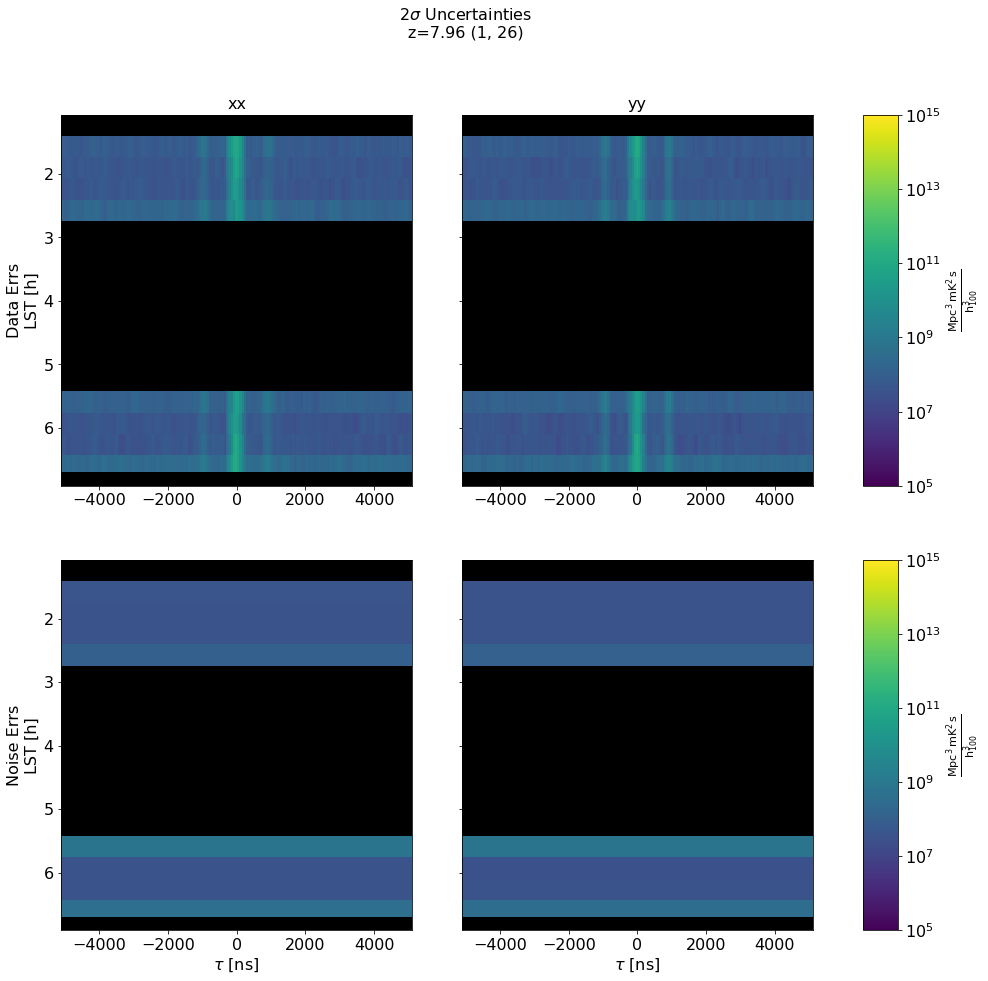

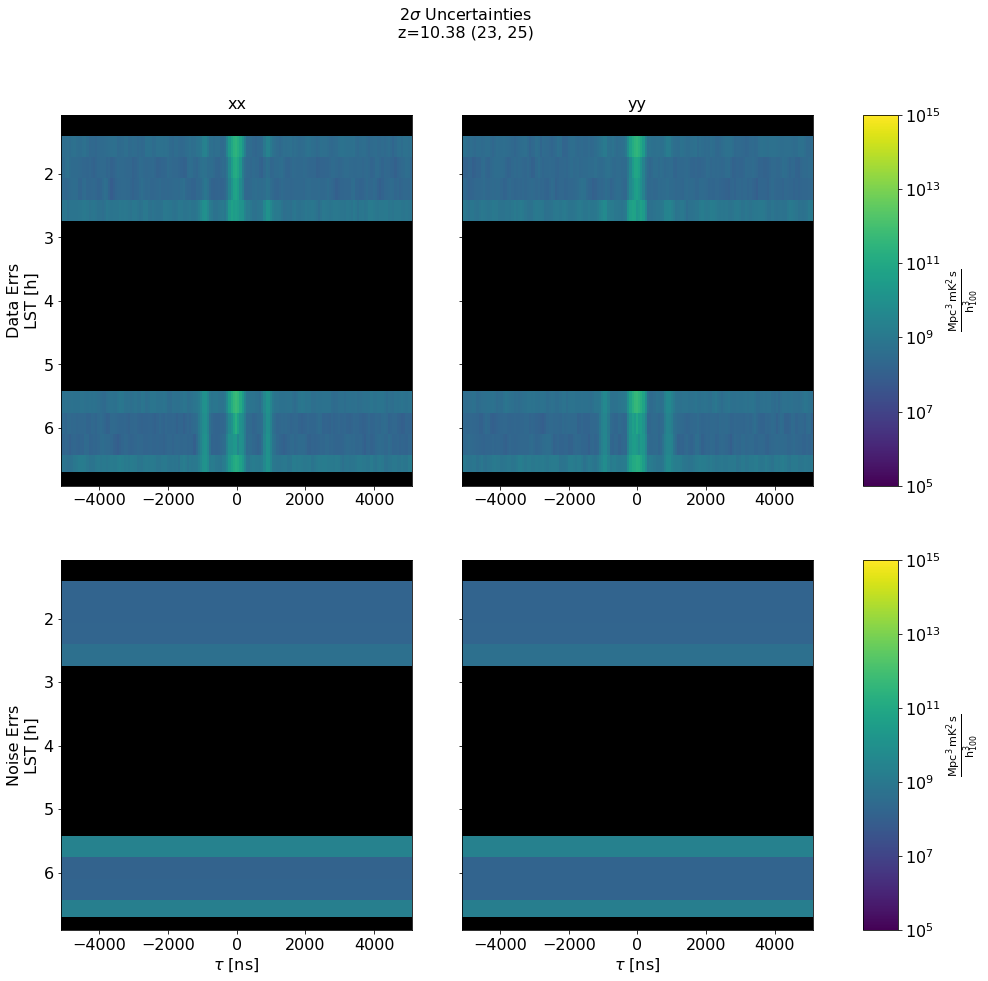

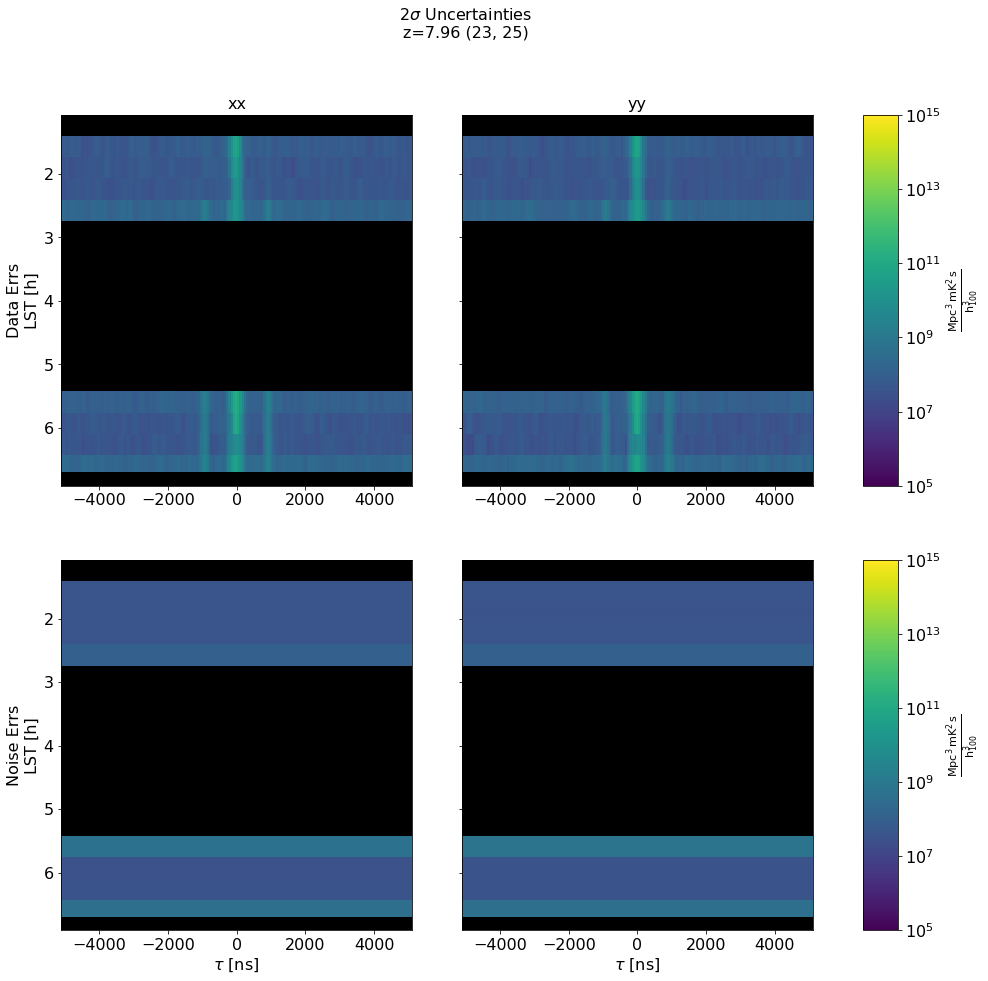

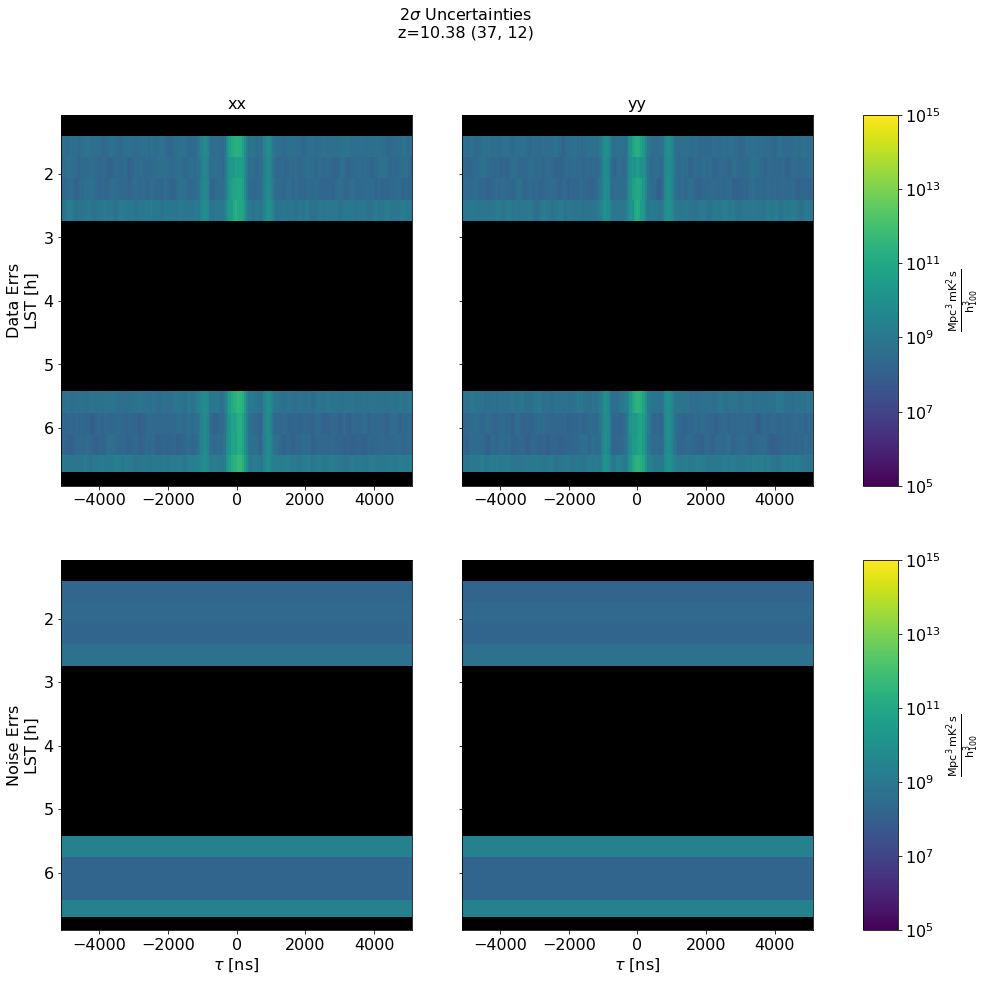

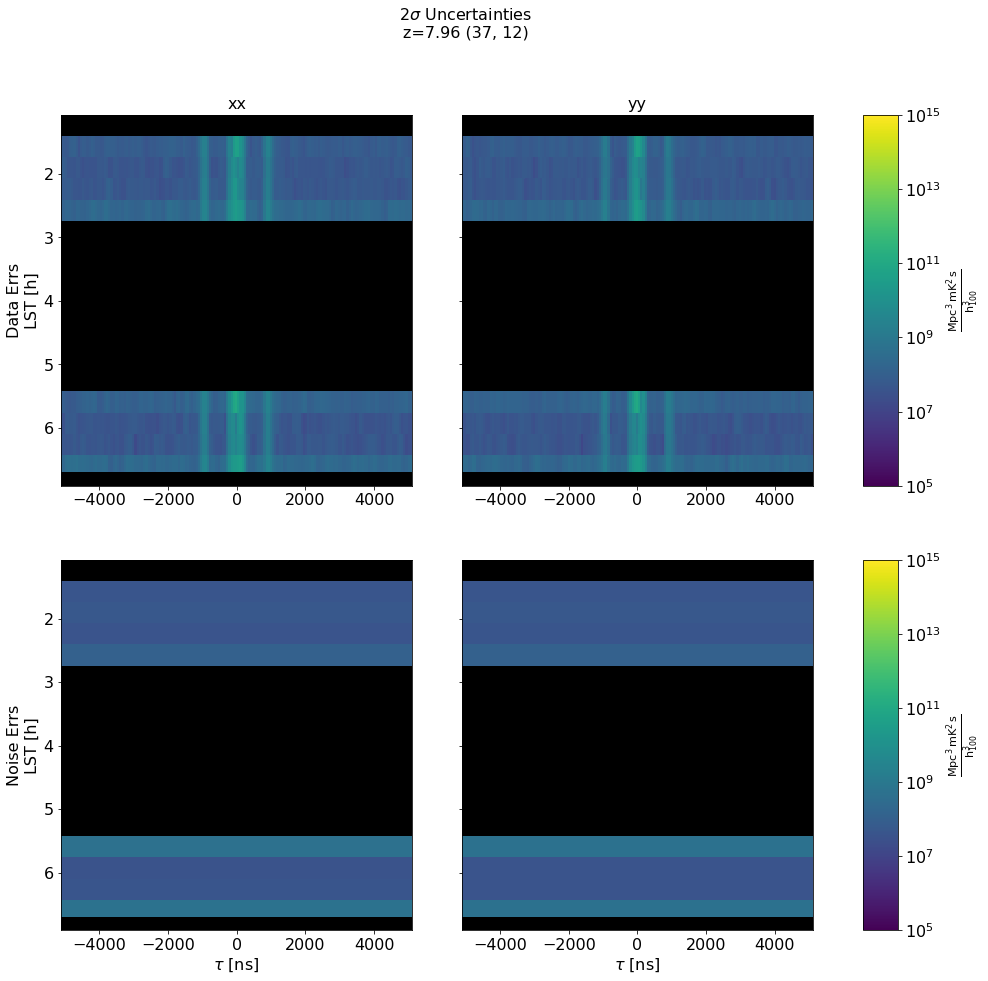

In [46]:
norm = LogNorm(vmin=1e5, vmax=1e15)
for cnt, _d in enumerate(ds_list):
    # plot waterfalls of errorbars
    for z_cnt, redshift in enumerate(_d.redshift):
        fig, ax = plt.subplots(
            ncols=_d.Npols + 1, 
            nrows=2, 
            figsize=(15,5 * 3),
            facecolor='white',
            squeeze=False,
            gridspec_kw={"width_ratios":[10] * ncols + [1]},
        )
        fig.suptitle(
            r"2$\sigma$ Uncertainties"
            f"\nz={_d.redshift[z_cnt]:.2f} "
            f"{uvutils.baseline_to_antnums(_d.baseline_array[0], _d.Nants_telescope)}" ,
            fontsize=16
        )
        sharedy = ax[0, 0].get_shared_y_axes()
        sharedx = ax[0, 0].get_shared_x_axes()

        for pol_ind, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):

            vals = np.ma.masked_invalid(values[cnt, z_cnt, pol_ind].real)
            errs = 2 * errors[cnt,z_cnt, pol_ind].real
            n_vals = np.ma.masked_invalid(noise_values[cnt, z_cnt, pol_ind].real)
            n_errs = 2 * noise_errors[cnt, z_cnt, pol_ind].real
            
            pn_noise = 2 * pn_sim[cnt, z_cnt, pol_ind].real

            masked_data = np.ma.masked_array(errs.value, mask=vals.mask)
            im = ax[0, pol_ind].pcolormesh(
                _d.delay_array.to('ns'),
                _d.lst_array.to("hourangle"),
                masked_data,
                cmap=cmap,
                norm=norm,
                shading="auto",
            )
            im.set_rasterized(True)

            masked_data = np.ma.masked_array(
                pn_noise.value,
                mask=n_vals.mask,
            )

            im1 = ax[1, pol_ind].pcolormesh(
                _d.delay_array.to('ns'),
                _d.lst_array.to("hourangle"),
                masked_data,
                cmap=cmap,
                norm=norm,
                shading="auto",
            )
            im1.set_rasterized(True)
            
            ax[0, pol_ind].set_title(
                f"{uvutils.polnum2str(_d.polarization_array[pol_ind])}",
                fontsize=16,
            )
            ax[0,pol_ind].set_ylabel("Data Errs\nLST [h]", fontsize=16)
            ax[1, pol_ind].set_ylabel("Noise Errs\nLST [h]", fontsize=16)


            for i in range(ax.shape[0]):

                sharedy.join(ax[0, 0], ax[i, pol_ind])
                sharedx.join(ax[0, 0], ax[i, pol_ind])
                plt.setp(ax[i, pol_ind].get_xticklabels(), fontsize=16)
                plt.setp(ax[i, pol_ind].get_yticklabels(), fontsize=16)

            if  0 < pol_ind < ncols + 1 - 1:
                plt.setp(ax[0, pol_ind].get_yticklabels(), visible=False)
                plt.setp(ax[1, pol_ind].get_yticklabels(), visible=False)
                ax[0, pol_ind].set_ylabel("")
                ax[1, pol_ind].set_ylabel("")

            ax[1, pol_ind].set_xlabel(r"$\tau$ [ns]", fontsize=16)
            ax[0, pol_ind].set_xlabel(r"")
#             ax[0, pol_ind].axvline(1000*units.ns, color='red')

        cbar = fig.colorbar(
            im,
            cax=ax[0, -1],
            label=(_d.power_array.unit * units.s).to_string("latex"),
        )
        cbar.ax.set_ylabel(
            cbar.ax.get_ylabel(),
            fontsize=16,
        )
        plt.setp(cbar.ax.get_yticklabels(), fontsize=16)
        cbar = fig.colorbar(
            im1,
            cax=ax[1, -1],
            label=(_d.power_array.unit * units.s).to_string("latex"),
        )

        cbar.ax.set_xlabel(
            cbar.ax.get_xlabel(),
            fontsize=16,
        )
        cbar.ax.set_ylabel(
            cbar.ax.get_ylabel(),
            fontsize=16,
        )
        plt.setp(cbar.ax.get_yticklabels(), fontsize=16)
        

        _ylim = ax[0, 0].get_ylim()
        ax[0, 0].set_ylim([np.max(_ylim), np.min(_ylim)])
        plt.savefig(f"set1_pspec_variance_z{redshift:.0f}.pdf")
    

In [47]:
avg_values = values.value.copy()
avg_errors = errors.value.copy()
avg_noise_values = noise_values.value.copy()
avg_noise_errors = noise_errors.value.copy()
avg_thermals = thermal_estimates.value.copy()
avg_pn_sim = pn_sim.value.copy()

w = np.tile(
    avg_thermals.real,
    (avg_values.shape[-1], 1, 1, 1, 1)
).transpose([1,2,3,4,0])
# pn_weights = np.ma.masked_invalid(1./avg_pn_sim.real**2 + 1j/avg_pn_sim.imag**2)
pn_weights = np.ma.masked_invalid(1./w.real**2 + 1j/w.real**2)
# weights = np.ma.masked_invalid(1./avg_errors.real**2 + 1j/avg_errors.imag**2)

# initialize masked arrays
avg_values = np.ma.masked_invalid(avg_values)
avg_errors = np.ma.masked_invalid(avg_errors)
avg_noise_values = np.ma.masked_invalid(avg_noise_values)
avg_noise_errors = np.ma.masked_invalid(avg_noise_errors)
avg_pn_sim = np.ma.masked_invalid(avg_pn_sim)

# mask where entire time is 0
avg_values.mask |= np.ma.all(avg_values==0, axis=4, keepdims=True)
avg_noise_values.mask |= np.ma.all(avg_noise_values==0, axis=4, keepdims=True)
avg_thermals = np.ma.masked_array(avg_thermals, mask=np.all(avg_values.mask, axis=4))

# harmonize masks
avg_values.mask |= avg_errors.mask
avg_values.mask |= pn_weights.mask 
avg_errors.mask = avg_values.mask
pn_weights.mask = avg_values.mask
avg_pn_sim.mask = avg_values.mask 

avg_noise_values.mask |= avg_noise_errors.mask
avg_noise_values.mask |= pn_weights.mask
avg_noise_errors.mask = avg_noise_values.mask

# average over time dimension
avg_values, avg_errors = np.array(
    utils.weighted_average(avg_values.real, avg_errors.real, weights=pn_weights.real, axis=(3))
) + 1j * np.array(
    utils.weighted_average(avg_values.imag, avg_errors.imag, weights=pn_weights.imag, axis=(3))
)

avg_noise_values, avg_noise_errors = np.array(
    utils.weighted_average(avg_noise_values.real, avg_noise_errors.real, weights=pn_weights.real, axis=(3))
) + 1j * np.array(
    utils.weighted_average(avg_noise_values.imag, avg_noise_errors.imag, weights=pn_weights.imag, axis=(3))
)


_, w = utils.weighted_average(np.ones_like(avg_pn_sim.real), avg_pn_sim.real, weights=pn_weights.real, axis=(4))

_, avg_pn_sim = np.array(
    utils.weighted_average(np.ones_like(avg_pn_sim.real), avg_pn_sim.real, weights=pn_weights.real, axis=3)
) + 1j * np.array(
    utils.weighted_average(np.ones_like(avg_pn_sim.imag), avg_pn_sim.imag, weights=pn_weights.imag, axis=3)
)

# averaged weights over delay dimension 
# t1 = avg_thermals.mean((-1,-2))
_, avg_thermals = utils.weighted_average(np.ones_like(avg_thermals), avg_thermals, axis=(3)) 
# t2 = avg_thermals.mean(-1)
# print(t1, t2, t1/t2, np.sqrt(pn_weights.shape[3]))

# re-apply units because masked quantites are dumb
avg_values = avg_values * _d.power_array.unit
avg_errors = avg_errors * _d.power_array.unit
avg_noise_values = avg_noise_values * _d.power_array.unit
avg_noise_errors = avg_noise_errors * _d.power_array.unit
avg_pn_sim = avg_pn_sim * _d.power_array.unit
avg_thermals = avg_thermals * _d.power_array.unit 

In [48]:
Pn_theory = np.zeros(
    (
        len(ds_list),
        np.max([_d.Nspws for _d in ds_list]),
        np.max([_d.Npols for _d in ds_list]),
    )
) * ds_list[0].power_array.unit
beam_crossing = np.zeros(
    (
        len(ds_list),
        np.max([_d.Nspws for _d in ds_list]),
    )
) * units.min

for cnt, _d in enumerate(ds_list):
    for z_cnt, z in enumerate(_d.redshift):
        for pol_ind, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
            crossing = (
                np.arcsin(
                    (const.c / _d.freq_array[z_cnt].mean()) # lambda
                    / np.linalg.norm(_d.uvw) # D
                )
                * 12 * units.h / (np.pi * units.rad) # unit conversion for a day
                / np.cos(uv.telescope_location_lat_lon_alt[0]) # account for latitude of array
            ).to(units.min)
            beam_crossing[cnt, z_cnt] = crossing
            tsys = 180 * np.power(_d.freq_array[z_cnt].mean().to('GHz') / (.18 * units.GHz), -2.55) * units.K
            tsys += _d.trcvr.item(0)
            tsys <<= units.mK

            omega_eff = _d.beam_area[z_cnt, pol_cnt].mean()**2 / _d.beam_sq_area[z_cnt, pol_cnt].mean()

            # this is for unweighted averaging in time
            # n_days = np.sqrt(1./np.ma.mean(np.ma.masked_invalid(1./(_d.nsample_array[z_cnt,:,pol_ind]* ~_d.flag_array[0, :, 0])**2), axis=(0,1,2,3)))

            # this is for inv var weighting in time
            masked_days = np.ma.masked_array(_d.nsample_array[z_cnt,:,pol_ind], mask=_d.flag_array[z_cnt,:,pol_ind])
            n_days = np.ma.sqrt(np.ma.mean(masked_days**2))
            X2Y = cosmo.X2Y(z)
            t_int = _d.integration_time.item(0)
            Nbls = _d.Nbls
            
            # These simulations have something weird going on where even at 10.7s integrations, the data is spaced at 21.4s
#             time_length = (np.mean(np.diff(_d.lst_array))  * 12 * units.h / (np.pi * units.rad)).si * _d.Ntimes / 2 
#             Nlst = (time_length / crossing).si
#             Nlst = (time_length / _d.integration_time.item(0)).si
#             Nlst =  _d.integration_time.item(0).si * _d.Ntimes / beam_crossing.si
            Nlst =  _d.Ntimes 

            Pn =  X2Y * omega_eff * tsys ** 2
            Pn /=  t_int * n_days * Nbls * np.sqrt(2 * Nlst)
            Pn_theory[cnt, z_cnt, pol_ind] = Pn.to(_d.power_array.unit, units.with_H0(cosmo.default_cosmology.get().H0))
            if pol_ind == 0:
                print(f"""z={z:.3f} {np.array2string(_d.uvw, precision=2)} {_d.uvw.unit.to_string()}
----------
X2Y: {X2Y:.3e}
trcvr: {_d.trcvr.item(0)}
tsys: {tsys:.3f}
omega_eff: {omega_eff:.3f}
n_days: {n_days:.3f}
t_int: {t_int:.3f}
Nbls: {Nbls}
beam_crossing: {beam_crossing[cnt, z_cnt]:.3f}
Nlst: {Nlst:.3f}

P_n: {Pn_theory[cnt, z_cnt, pol_ind]:.3e}

"""
)

z=10.385 [1.47e+01 2.55e+01 3.55e-07] m
----------
X2Y: 1.787e+03 Mpc3 s / sr
trcvr: 50.0 K
tsys: 506821.549 mK
omega_eff: 0.127 sr
n_days: 13.505
t_int: 300.440 s
Nbls: 9
beam_crossing: 21.785 min
Nlst: 18.000

P_n: 8.291e+07 mK2 Mpc3 / littleh3


z=7.960 [1.47e+01 2.55e+01 3.55e-07] m
----------
X2Y: 1.396e+03 Mpc3 s / sr
trcvr: 50.0 K
tsys: 298363.650 mK
omega_eff: 0.082 sr
n_days: 13.826
t_int: 300.440 s
Nbls: 9
beam_crossing: 17.147 min
Nlst: 18.000

P_n: 1.412e+07 mK2 Mpc3 / littleh3


z=10.385 [ 2.94e+01 -4.53e-07 -7.62e-07] m
----------
X2Y: 1.787e+03 Mpc3 s / sr
trcvr: 50.0 K
tsys: 506821.549 mK
omega_eff: 0.127 sr
n_days: 13.603
t_int: 300.440 s
Nbls: 9
beam_crossing: 21.785 min
Nlst: 18.000

P_n: 8.231e+07 mK2 Mpc3 / littleh3


z=7.960 [ 2.94e+01 -4.53e-07 -7.62e-07] m
----------
X2Y: 1.396e+03 Mpc3 s / sr
trcvr: 50.0 K
tsys: 298363.650 mK
omega_eff: 0.082 sr
n_days: 13.927
t_int: 300.440 s
Nbls: 9
beam_crossing: 17.147 min
Nlst: 18.000

P_n: 1.402e+07 mK2 Mpc3 / littleh3




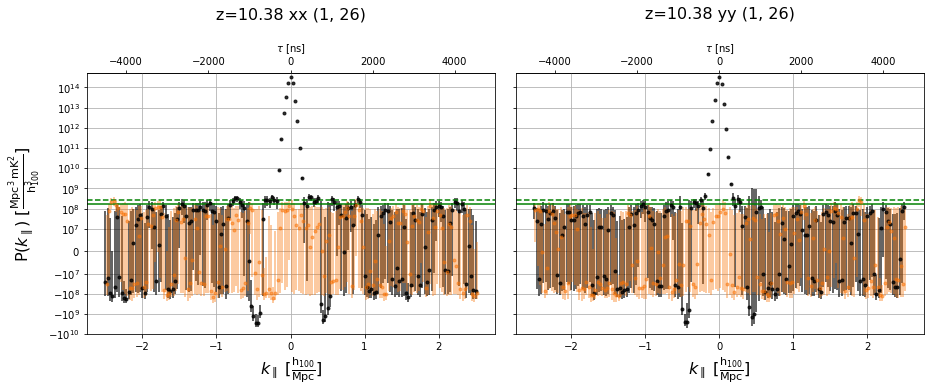

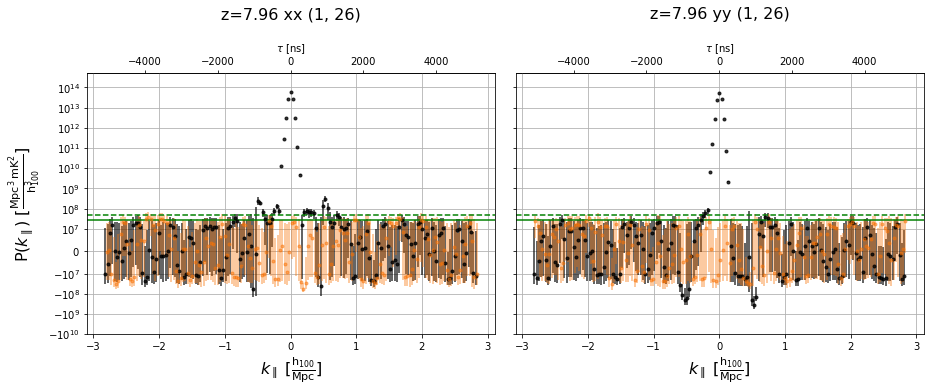

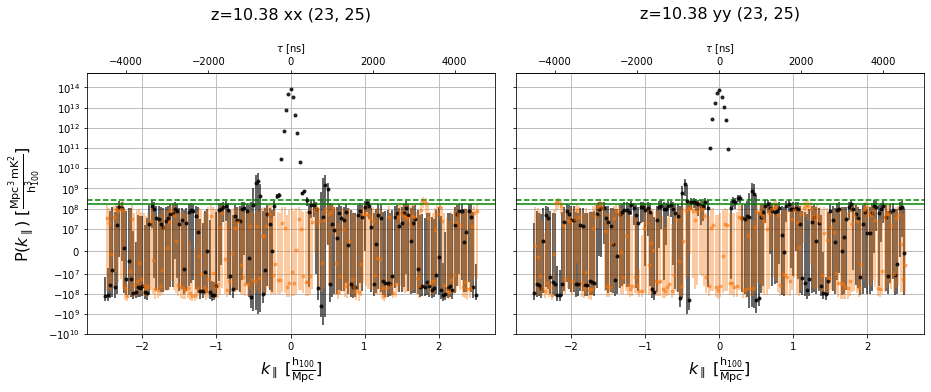

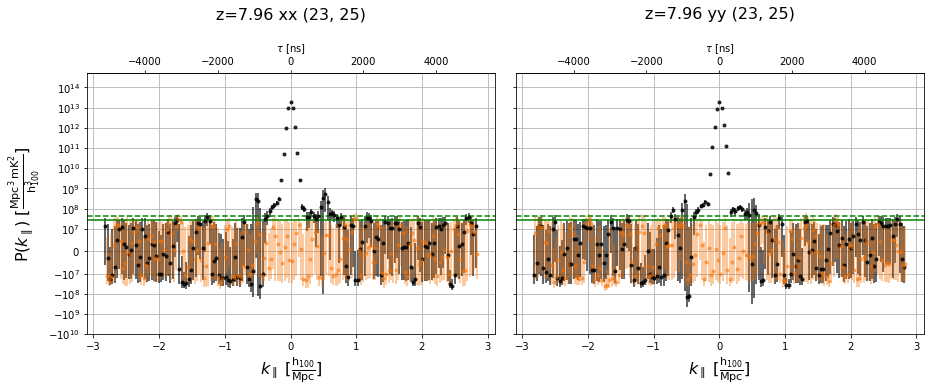

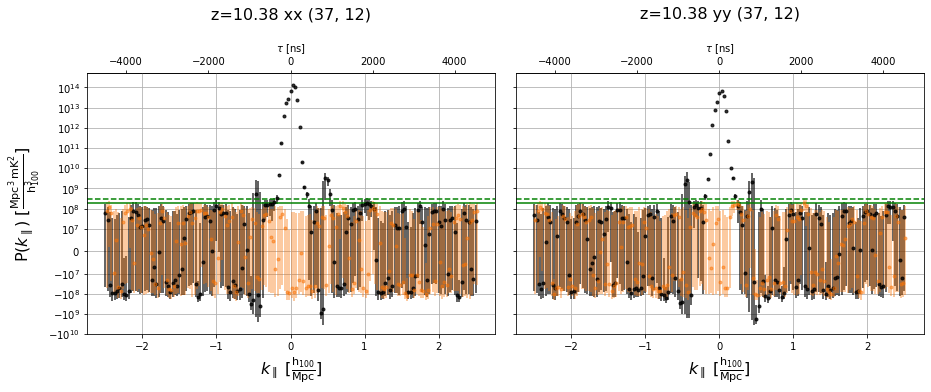

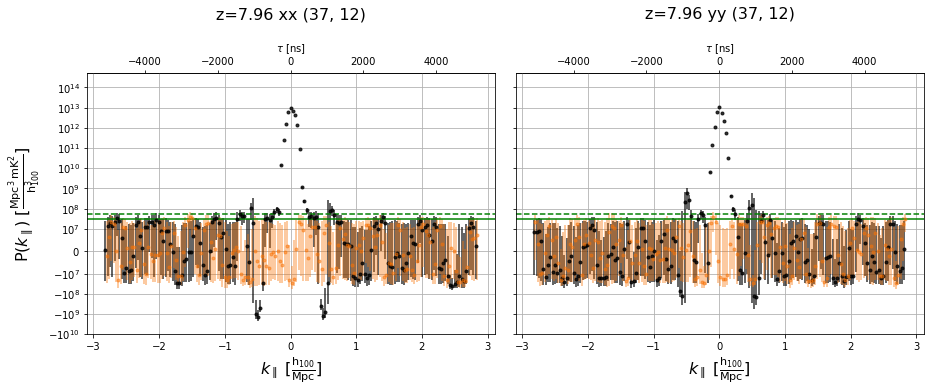

In [49]:
for cnt, _d in enumerate(ds_list):
    for z_cnt, redshift in enumerate(_d.redshift):
        fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=(15,5),
            facecolor='white',
            sharex=True,
            sharey=True,
            squeeze=False
        )
        ax = ax.ravel()
        
        for pol_ind, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
            
            
            
            vals = avg_values[cnt, z_cnt, pol_ind].real
            errs = 2 * avg_errors[cnt, z_cnt, pol_ind].real
            n_vals = avg_noise_values[cnt, z_cnt, pol_ind].real
            n_errs = 2 * avg_noise_errors[cnt, z_cnt, pol_ind].real
            taus = _d.delay_array
            good_taus = np.logical_and(2000  * units.ns <= np.abs(taus), np.abs(taus) <= 3000 * units.ns)

#             iv_mean =  np.average(vals[good_taus], weights=1. / (errs[good_taus]) ** 2)
#             iv_err = np.sqrt(1./np.sum(1. / (errs[good_taus])**2))
#             iv_chi2 = np.sum((iv_mean - vals[good_taus]) ** 2 / ((errs[good_taus]) ** 2))
            
#             u_mean =  np.average(vals[good_taus])
#             u_err = np.sqrt(np.sum(errs[good_taus] ** 2)/np.abs(errs[good_taus].size) **2 )
#             u_chi2 = np.sum((u_mean - vals[good_taus]) ** 2 / ((errs[good_taus]) ** 2))
            
            
#             dof = (ds.Ndelays * utils.noise_equivalent_bandwidth(ds.taper(ds.Nfreqs)) - 1)
#             dof = (sum(good_taus) *  utils.noise_equivalent_bandwidth(ds.taper(ds.Nfreqs)) - 1)
            ax[pol_ind].errorbar(
                _d.k_parallel[z_cnt],
                vals,
                errs,
                fmt='k.', alpha=.8,
                label="Data" if pol_ind==0 else ''
            );
            ax[pol_ind].errorbar(
                _d.k_parallel[z_cnt] + np.diff(_d.k_parallel[z_cnt])[0]/2.,
                n_vals,
                n_errs,
                fmt='.', color="XKCD:Orange", alpha=.5,
                label="Data" if pol_ind==0 else ''
            );

            ax[pol_ind].axhline(2 * avg_thermals[cnt, z_cnt, pol_ind], color="green", linestyle="--")
            ax[pol_ind].axhline(2 * Pn_theory[cnt, z_cnt, pol_ind], color="green", linestyle="-")

            ax[pol_ind].grid()
            ax[pol_ind].set_xlabel(r'$k_{{\parallel}}$ [{0}]'.format(_d.k_parallel.unit.to_string('latex')), fontsize=16)
            ax[pol_ind].set_title(
                f"z={_d.redshift[z_cnt]:.2f} "
                f"{uvutils.polnum2str(_d.polarization_array[pol_ind])} "
                f"{uvutils.baseline_to_antnums(_d.baseline_array[0], _d.Nants_telescope)}\n" 
#                 r" $\hat{\mu}$="
#                 f"{sci_notation(iv_mean, iv_err, decimal_digits=2)} "
#                 r"$\frac{\chi^{2}}{dof}$="
#                 f"{iv_chi2/dof:.3f}\n"
#                 r" $\hat{\mu}_{u}$="
#                 f"{sci_notation(u_mean, u_err, decimal_digits=2)} "
#                 r"$\frac{\chi^{2}}{dof}$="
#                 f"{u_chi2/dof:.3f}\n"
                , fontsize=16)
            if pol_ind == 0:
                ax[pol_ind].set_ylabel(r'P($k_{{\parallel}}$) [{0}]'.format((_d.power_array.unit).to_string('latex')), fontsize=16)
            else:
                ax[pol_ind].set_ylabel("")
            
            def forward(x):
                x = x * ds.k_parallel.unit
                x = x.to("1/Mpc", units.with_H0(cosmo.default_cosmology.get().H0))
                return cosmo.kparr2eta(x, redshift).to_value("ns")
            def inverse(x):
                x = cosmo.eta2kparr(x  * _d.delay_array.unit, redshift)
                x = x.to(_d.k_parallel.unit, units.with_H0(cosmo.default_cosmology.get().H0)).value
                return x
            secax = ax[pol_ind].secondary_xaxis('top', functions=(forward, inverse))
            secax.set_xlabel(r"$\tau$ [ns]")
            
        sharex = ax[0].get_shared_x_axes()
        for pol_cnt in range(_d.polarization_array.size):
            sharex.join(ax[0], ax[pol_cnt])

        sharey = ax[0].get_shared_y_axes()
        for pol_cnt in range(ds.polarization_array.size):
            sharey.join(ax[0], ax[pol_cnt])
        ax[0].set_yscale('symlog', linthresh=1e7)
        ax[0].set_ylim(-1e10, 5e14)
        fig.subplots_adjust(wspace=.05, hspace=.175, top=.85)

In [50]:
# fold over delay
taus = _d.delay_array[(_d.Ndelays -1 )//2:]
avg_values, avg_errors = utils.fold_along_delay(_d.delay_array, avg_values, avg_errors, weights=1./avg_errors.real**2 + 1j/avg_errors.imag**2)
avg_noise_values, avg_noise_errors = utils.fold_along_delay(_d.delay_array, avg_noise_values, avg_noise_errors, weights=1./avg_noise_errors.real**2 + 1j/avg_noise_errors.imag**2)
_, avg_pn_sim = utils.fold_along_delay(_d.delay_array, np.ones_like(avg_pn_sim), avg_pn_sim, weights=1./avg_pn_sim.real**2 + 1j/avg_pn_sim.imag**2)

# Divide thermal estimates by root(2) because folding
avg_thermals /= np.sqrt(2)                      
avg_pn = Pn_theory.value.copy() / np.sqrt(2)
                                  

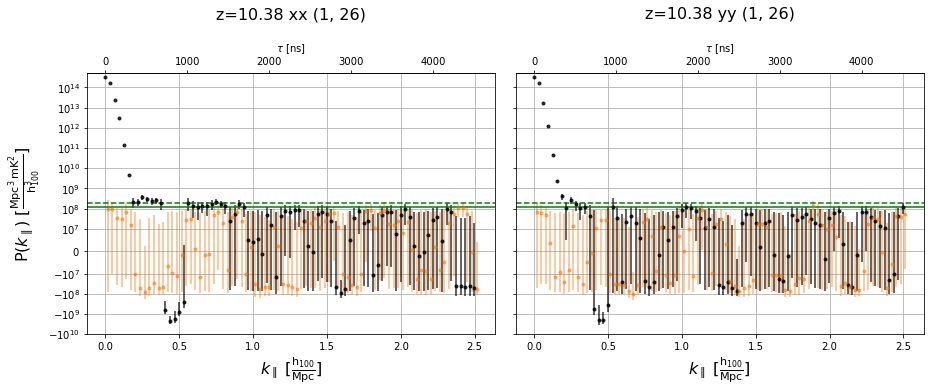

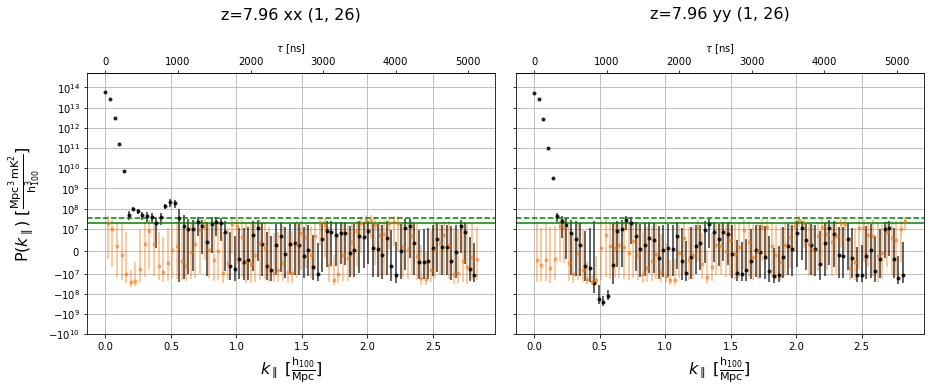

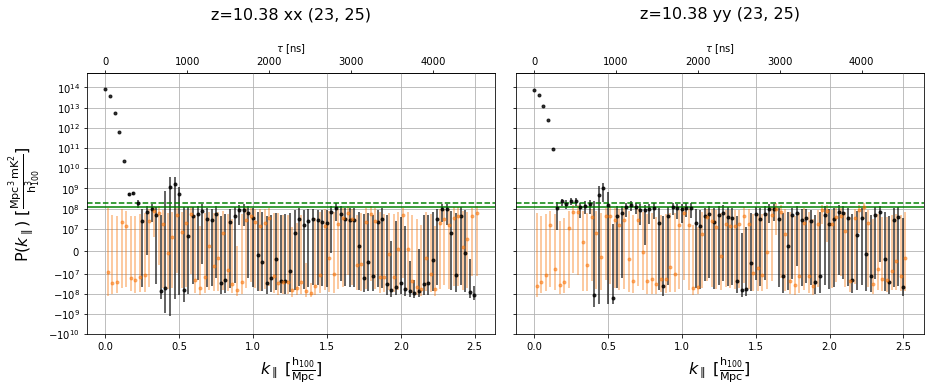

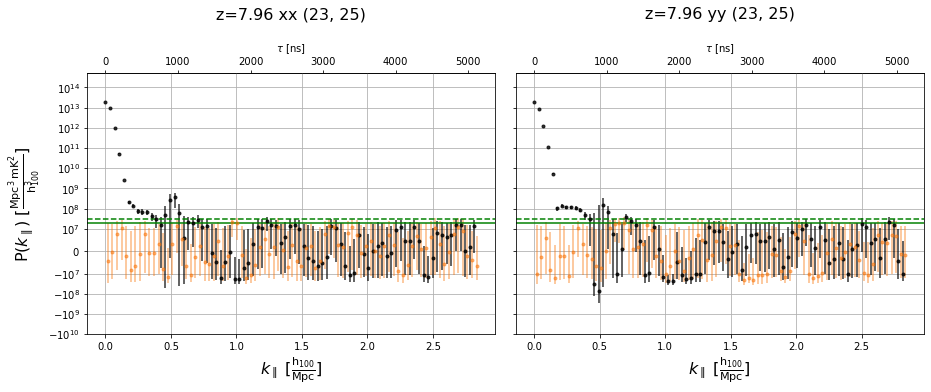

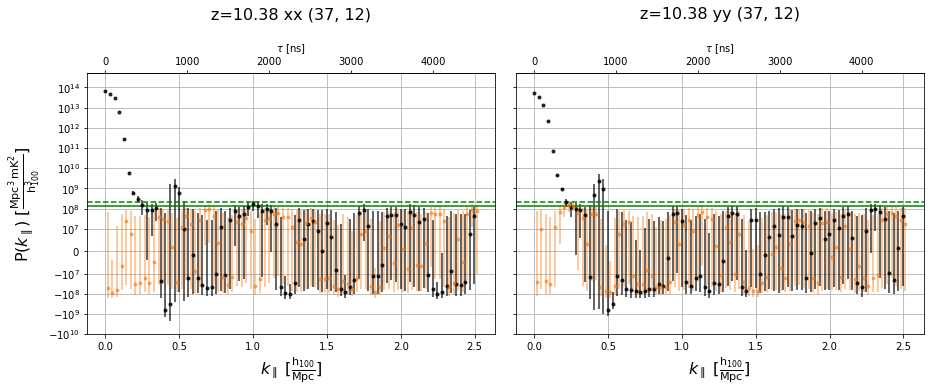

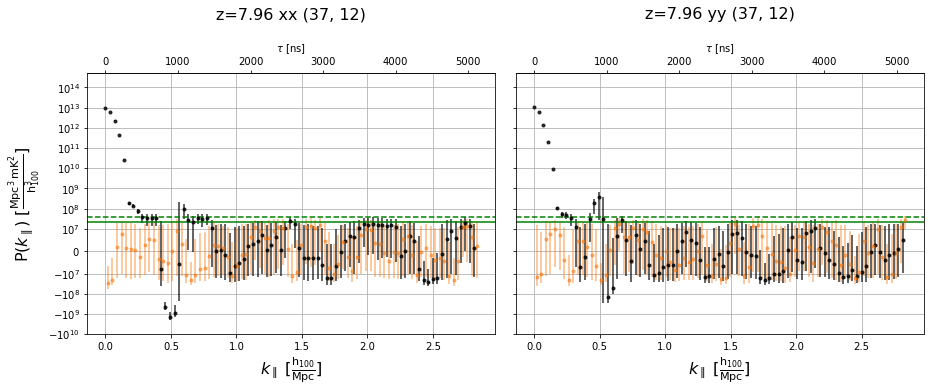

In [51]:
for cnt, _d in enumerate(ds_list):

    for z_cnt, redshift in enumerate(_d.redshift):
        fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=(15,5),
            facecolor='white',
            sharex=True,
            sharey=True,
            squeeze=False
        )
        ax = ax.ravel()
        
        for pol_ind, pol in enumerate(uvutils.polnum2str(_d.polarization_array)):
            
            ax[pol_ind].errorbar(
                _d.k_parallel[z_cnt][(_d.Ndelays -1 )//2:],
                avg_values[cnt, z_cnt, pol_ind].real,
                2 * avg_errors[cnt, z_cnt, pol_ind].real,
                fmt='k.', alpha=.8,
                label="Data" if pol_ind==0 else ''
            );
            ax[pol_ind].errorbar(
                _d.k_parallel[z_cnt][(_d.Ndelays -1 )//2:] + np.diff(_d.k_parallel[z_cnt])[0]/2.,
                avg_noise_values[cnt, z_cnt, pol_ind].real,
                2 * avg_noise_errors[cnt, z_cnt, pol_ind].real,
                fmt='.', color="XKCD:Orange", alpha=.5,
                label="Data" if pol_ind==0 else ''
            );
         
            thermal_factor = 2
            ax[pol_ind].axhline(2 * avg_thermals[cnt, z_cnt, pol_ind], color="green", linestyle="--")
            ax[pol_ind].axhline(2 * avg_pn[cnt, z_cnt, pol_ind], color="green", linestyle="-")
            
            ax[pol_ind].grid()
            ax[pol_ind].set_xlabel(r'$k_{{\parallel}}$ [{0}]'.format(_d.k_parallel.unit.to_string('latex')), fontsize=16)
            ax[pol_ind].set_title(
                f"z={_d.redshift[z_cnt]:.2f} "
                f"{uvutils.polnum2str(_d.polarization_array[pol_ind])} "
                f"{uvutils.baseline_to_antnums(_d.baseline_array[0], _d.Nants_telescope)}\n" 
#                 r" $\hat{\mu}$="
#                 f"{sci_notation(iv_mean, iv_err, decimal_digits=2)} "
#                 r"$\frac{\chi^{2}}{dof}$="
#                 f"{iv_chi2/dof:.3f}\n"
#                 r" $\hat{\mu}_{u}$="
#                 f"{sci_notation(u_mean, u_err, decimal_digits=2)} "
#                 r"$\frac{\chi^{2}}{dof}$="
#                 f"{u_chi2/dof:.3f}\n"
                , fontsize=16)
            if pol_ind == 0:
                ax[pol_ind].set_ylabel(r'P($k_{{\parallel}}$) [{0}]'.format((_d.power_array.unit).to_string('latex')), fontsize=16)
            else:
                ax[pol_ind].set_ylabel("")
            
            def forward(x):
                x = x * _d.k_parallel.unit
                x = x.to("1/Mpc", units.with_H0(cosmo.default_cosmology.get().H0))
                return cosmo.kparr2eta(x, redshift).to_value("ns")
            def inverse(x):
                x = cosmo.eta2kparr(x  * _d.delay_array.unit, redshift)
                x = x.to(_d.k_parallel.unit, units.with_H0(cosmo.default_cosmology.get().H0)).value
                return x
            secax = ax[pol_ind].secondary_xaxis('top', functions=(forward, inverse))
            secax.set_xlabel(r"$\tau$ [ns]")
            
#             ax[pol_ind].axvspan(inverse(2000), inverse(3000), color="red", alpha=.25, hatch="/", fill=False)
#             ax[pol_ind].axvspan(inverse(-3000), inverse(-2000), color="red", alpha=.25, hatch="/", fill=False)
            
            
        
        sharex = ax[0].get_shared_x_axes()
        for pol_cnt in range(_d.polarization_array.size):
            sharex.join(ax[0], ax[pol_cnt])

        sharey = ax[0].get_shared_y_axes()
        for pol_cnt in range(_d.polarization_array.size):
            sharey.join(ax[0], ax[pol_cnt])
        ax[0].set_yscale('symlog', linthresh=1e7)
        ax[0].set_ylim(-1e10, 5e14)
        fig.subplots_adjust(wspace=.05, hspace=.175, top=.85)
        fig.suptitle(
            f" " 
        );
        plt.savefig(f"set1_z{redshift:.0f}_{'{0}_{1}'.format(*uvutils.baseline_to_antnums(_d.baseline_array[0], _d.Nants_telescope))}.pdf", bbox_inches="tight")

In [52]:
pn_weights = np.ma.masked_invalid(1./avg_pn_sim.real.value**2 + 1j/avg_pn_sim.imag.value**2)
pn_weights = pn_weights
# initialize masked arrays
avg_values = np.ma.masked_invalid(avg_values.value)
avg_errors = np.ma.masked_invalid(avg_errors.value)
avg_noise_values = np.ma.masked_invalid(avg_noise_values.value)
avg_noise_errors = np.ma.masked_invalid(avg_noise_errors.value)
avg_pn_sim = np.ma.masked_invalid(avg_pn_sim.value)
# avg_errors = np.ma.masked_invalid(1./avg_errors.real**2 + 1j/avg_errors.imag**2)


if False:
    pn_weights = pn_weights[:2]
    avg_values = avg_values[:2]
    avg_errors = avg_errors[:2]
    avg_noise_values = avg_noise_values[:2]
    avg_noise_errors = avg_noise_errors[:2]
    avg_pn_sim = avg_pn_sim[:2]

# harmonize masks
avg_values.mask |= avg_errors.mask
avg_values.mask |= pn_weights.mask 
avg_errors.mask = avg_values.mask
pn_weights.mask = avg_values.mask
avg_pn_sim.mask = avg_values.mask 

avg_noise_values.mask |= avg_noise_errors.mask
avg_noise_values.mask |= pn_weights.mask
avg_noise_errors.mask = avg_noise_values.mask
pn_weights.mask = avg_noise_values.mask



# average over baseline dimension
avg_values, avg_errors = np.array(
    utils.weighted_average(avg_values.real, avg_errors.real, weights=pn_weights.real, axis=0)
) + 1j * np.array(
    utils.weighted_average(avg_values.imag, avg_errors.imag, weights=pn_weights.imag, axis=0)
)

avg_noise_values, avg_noise_errors = np.array(
    utils.weighted_average(avg_noise_values.real, avg_noise_errors.real, weights=pn_weights.real, axis=0)
) + 1j * np.array(
    utils.weighted_average(avg_noise_values.imag, avg_noise_errors.imag, weights=pn_weights.imag, axis=0)
)

_, avg_pn_sim = np.array(
    utils.weighted_average(np.ones_like(avg_pn_sim.real), avg_pn_sim.real, weights=pn_weights.real, axis=0)
) + 1j * np.array(
    utils.weighted_average(np.ones_like(avg_pn_sim.imag), avg_pn_sim.imag, weights=pn_weights.imag, axis=0)
)

# averaged weights over delay dimension 
_, avg_thermals = utils.weighted_average(np.ones_like(avg_thermals.value), avg_thermals.value, axis=0) 

# re-apply units because masked quantites are dumb
avg_values = avg_values * _d.power_array.unit
avg_errors = avg_errors * _d.power_array.unit
avg_noise_values = avg_noise_values * _d.power_array.unit
avg_noise_errors = avg_noise_errors * _d.power_array.unit
avg_thermals = avg_thermals * _d.power_array.unit 
avg_pn_sim = avg_pn_sim * _d.power_array.unit

# collapse delay dimension for the Pn calc
# _, w = utils.weighted_average(np.ones_like(avg_pn_sim.real), avg_pn_sim, pn_weights.real, axis=(3))
_, avg_pn = utils.weighted_average(np.ones_like(avg_pn), avg_pn, axis=0) 
avg_pn = avg_pn  * _d.power_array.unit
       

In [53]:
with h5py.File(outfile, "w") as h5file:
    h5file["k_parallel"] = ds_list[0].k_parallel[:, 80:].value
    h5file["k_parallel"].attrs["unit"] = ds_list[0].k_parallel.unit.to_string()
    
    h5file["k_perpendicular"] = ds_list[0].k_perpendicular.value
    h5file["k_perpendicular"].attrs["unit"] = ds_list[0].k_perpendicular.unit.to_string()
    
    h5file["delays"] = taus.value
    h5file["delays"].attrs["unit"] = taus.unit.to_string()
    
    h5file["redshift"] = ds_list[0].redshift
    h5file["polarization_array"] = np.string_(
        uvutils.polnum2str(ds_list[0].polarization_array)
    )
    
    for name, array in {
        "avg_values": avg_values,
        "avg_errors": avg_errors,
        "avg_noise_values": avg_noise_values,
        "avg_noise_errors": avg_noise_errors,
        "avg_thermals": avg_thermals,
        "avg_pn": avg_pn,
    }.items():
        dset = h5file.create_dataset(
            name, chunks=True, data=array.value, compression=None, dtype=array.dtype
        )
        dset.attrs["unit"] = array.unit.to_string()

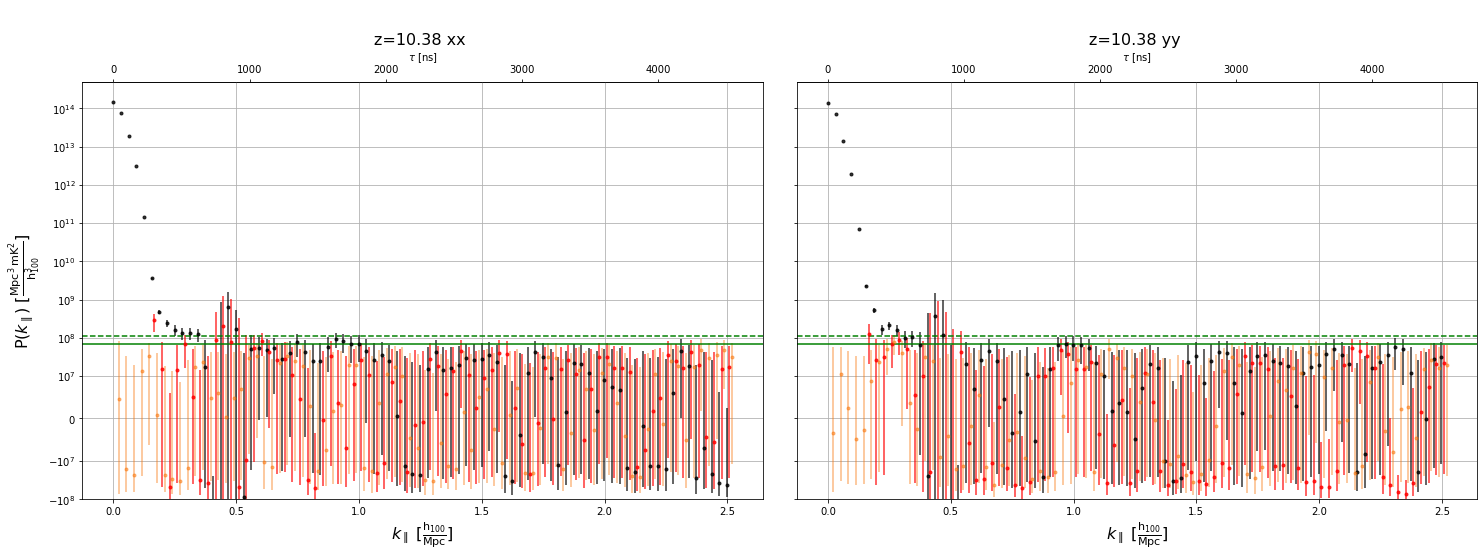

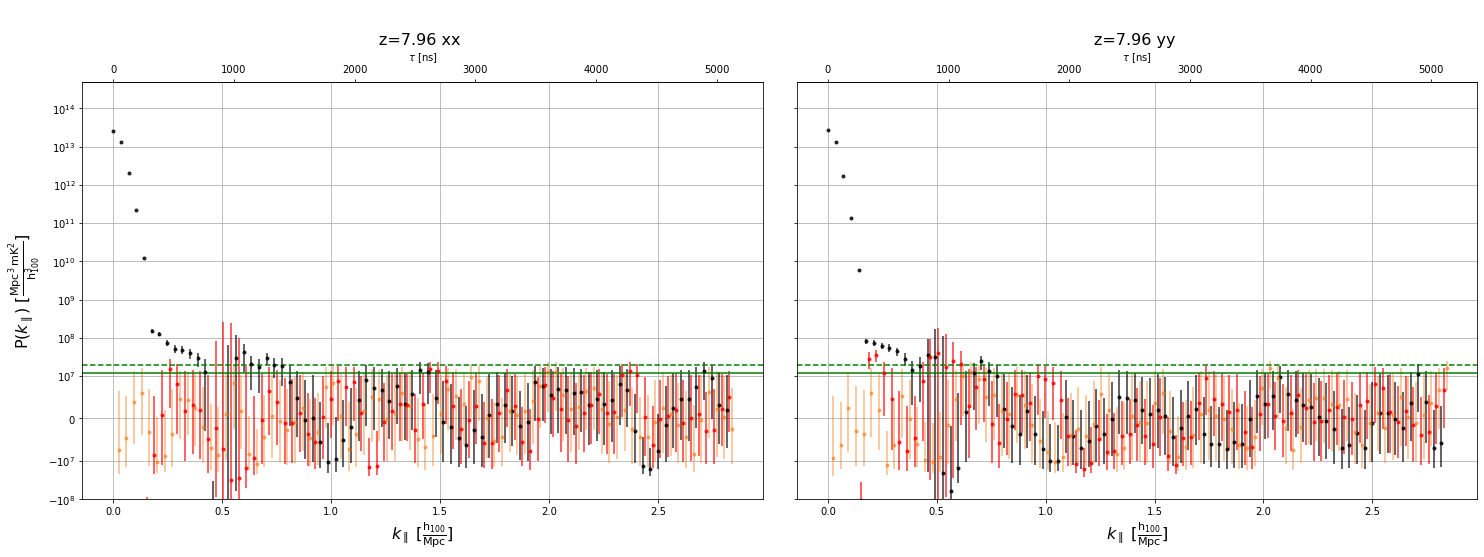

In [54]:
for z_cnt, redshift in enumerate(ds_list[0].redshift):
    fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=(25,8),
            facecolor='white',
            sharex=True,
            sharey=True,
            squeeze=False
        )
    ax = ax.ravel()

    for pol_ind, pol in enumerate(uvutils.polnum2str(ds_list[0].polarization_array)):
        ax[pol_ind].errorbar(
            ds_list[0].k_parallel[z_cnt][(_d.Ndelays -1 )//2:],
            avg_values[z_cnt, pol_ind].real,
            2 * avg_errors[z_cnt, pol_ind].real,
            fmt='k.', alpha=.8,
            label="Data" if pol_ind==0 else ''
        );
        ax[pol_ind].errorbar(
            ds_list[0].k_parallel[z_cnt][(_d.Ndelays -1 )//2:]+ np.diff(ds_list[0].k_parallel[z_cnt])[0]*1./3.,
            avg_values[z_cnt, pol_ind].imag,
            2 * avg_errors[z_cnt, pol_ind].imag,
            fmt='r.', alpha=.8,
            label="Data" if pol_ind==0 else ''
        );
        ax[pol_ind].errorbar(
            ds_list[0].k_parallel[z_cnt][(_d.Ndelays -1 )//2:] + np.diff(ds_list[0].k_parallel[z_cnt])[0]*2/3.,
            avg_noise_values[z_cnt, pol_ind].real,
            2 * avg_noise_errors[z_cnt, pol_ind].real,
            fmt='.', color="XKCD:Orange", alpha=.5,
            label="Data" if pol_ind==0 else ''
        );
#         ax[pol_ind].plot(
#             ds_list[0].k_parallel[z_cnt][80:],
#             psf[80:] * avg_values[z_cnt, pol_ind].max(),
                
#         )

        ax[pol_ind].axhline(2 * avg_pn[z_cnt, pol_ind], color="green")
        # multiply by a factor of 2 beacuse simpleDS overestimates the number of LST bins
        ax[pol_ind].axhline(2 * avg_thermals[z_cnt, pol_ind], color="green", linestyle="--")
        ax[pol_ind].set_xlabel(r'$k_{{\parallel}}$ [{0}]'.format(_d.k_parallel.unit.to_string('latex')), fontsize=16)
        ax[pol_ind].set_title(
            f"z={_d.redshift[z_cnt]:.2f} "
            f"{uvutils.polnum2str(_d.polarization_array[pol_ind])} "
            , fontsize=16,
        )
        if pol_ind == 0:
            ax[pol_ind].set_ylabel(r'P($k_{{\parallel}}$) [{0}]'.format((_d.power_array.unit).to_string('latex')), fontsize=16)
        else:
            ax[pol_ind].set_ylabel("")
        
        def forward(x):
            x = x * _d.k_parallel.unit
            x = x.to("1/Mpc", units.with_H0(cosmo.default_cosmology.get().H0))
            return cosmo.kparr2eta(x, redshift).to_value("ns")
        def inverse(x):
            x = cosmo.eta2kparr(x  * _d.delay_array.unit, redshift)
            x = x.to(_d.k_parallel.unit, units.with_H0(cosmo.default_cosmology.get().H0)).value
            return x
        secax = ax[pol_ind].secondary_xaxis('top', functions=(forward, inverse))
        secax.set_xlabel(r"$\tau$ [ns]")
        
    sharex = ax[0].get_shared_x_axes()
    for pol_cnt in range(_d.polarization_array.size):
        sharex.join(ax[0], ax[pol_cnt])
        ax[pol_cnt].grid();

    sharey = ax[0].get_shared_y_axes()
    for pol_cnt in range(_d.polarization_array.size):
        sharey.join(ax[0], ax[pol_cnt])
    ax[0].set_yscale('symlog', linthresh=1e7)
    ax[0].set_ylim(-1e8, 5e14)
    fig.subplots_adjust(wspace=.05, hspace=.175, top=.85)
    fig.suptitle(
        f" " 
    );

In [55]:
def correlation(x,y):
    x_bar = np.sum(x, keepdims=True, axis=-1)/ x.shape[-1]  
    y_bar = np.sum(y, keepdims=True, axis=-1)/ x.shape[-1]    
    return np.sum(
        (x - x_bar) * (y - y_bar),
        axis=-1
    ) / np.sqrt(
        np.sum((x - x_bar) ** 2, axis=-1)
        * np.sum((y - y_bar) ** 2, axis=-1)
    )

In [56]:
bad_ants = [0,2,11,24,50,53,54,67,69,98,122,136,139]
for ant in bad_ants:
    if np.logical_or(
        ant in uv.ant_1_array,
        ant in uv.ant_2_array,
    ):
        print(ant)